In [1]:
# !pip install kaggle
# from google.colab import files
# files.upload()

In [2]:
# !ls -1ha kaggle.json

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [5]:
!pip3 install tokenizers wandb sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 14.3 MB/s 
     |████████████████████████████████| 1.8 MB 77.3 MB/s 
     |████████████████████████████████| 1.2 MB 80.9 MB/s 
     |████████████████████████████████| 181 kB 84.7 MB/s 
     |████████████████████████████████| 145 kB 94.2 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=976eddfaff7ff9a61317b310ea20f9783777f4071e3a7bf4143d0962870b18db
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 14.0 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 85.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Kaggle')

In [8]:
OUTPUT_DIR = './pppm-roberta/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  9 15:04:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="roberta-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=50 # [0, 50, 100]
    epochs=5
    encoder_lr=1.5e-5 #2e-5
    decoder_lr=1.5e-5 #2e-5
    min_lr=5e-7
    eps=5e-7
    betas=(0.9, 0.999)
    batch_size=10
    fc_dropout=0.15
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    train_all_index=20
    n_fold=15
    trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [11]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb')
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-MSE', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [12]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [13]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [14]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [15]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


def get_cpc_texts_nakama():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
# cpc_texts = get_cpc_texts_nakama()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [16]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

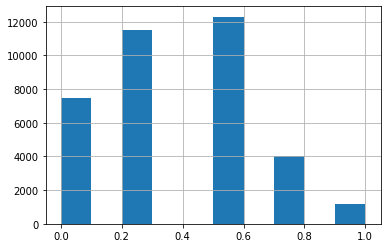

In [17]:
train['score'].hist()

In [18]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV Split

In [19]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [20]:
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})

# encoder = LabelEncoder()
# train['anchor_map'] = encoder.fit_transform(train['anchor'])

# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (_, valid_index) in enumerate(kf.split(train, train['score_map'], groups=train['anchor_map'])):
#     train.loc[valid_index, 'fold'] = int(n)

# train['fold'] = train['fold'].astype(int)

In [21]:
# titles = pd.read_csv('./titles.csv')
# train = train.merge(titles, left_on='context', right_on='code')
# train['fold'] = -1
# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

# for f, (t_, v_) in enumerate(kf.split(X=train, y=train['anchor'], groups=train['anchor'])):
#     train.loc[v_, 'fold'] = f

# train['fold'].hist()
# train['text'] = train['anchor'] + '[SEP]' + train['title'].apply(str.lower)
# train = train[['id','anchor', 'target', 'context', 'score', 'title', 'fold', 'text']]

In [22]:
!pip3 install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

684 49
684 49
684 49
684 49
684 49
684 49
684 49
684 49
685 48
684 49
684 49
684 49
684 49
684 49
685 48
1     2619
12    2572
6     2560
5     2541
3     2523
7     2498
8     2474
14    2422
2     2422
4     2404
11    2345
10    2330
9     2329
13    2291
0     2143
Name: fold, dtype: int64


In [23]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Tokenizer

In [24]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

# Dataset

In [25]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 175


In [26]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [27]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [28]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
            # self.model = AutoModelForSequenceClassification.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
            # self.model = AutoModelForSequenceClassification.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        # self.fc = nn.Linear(self.config.num_labels, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output



# Helper Functions

In [29]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)


        labels = labels.to(torch.float16)
        # print(y_preds.view(-1, 1).dtype)
        # print(labels.view(-1, 1).dtype)
        # loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # print(loss.dtype)

        
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        labels = labels.to(torch.float16)
        loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())

        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [30]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if fold != CFG.train_all_index:
        train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    else:
        train_folds = folds
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)

    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.MSELoss(reduction="mean")
    # criterion = FocalLossV1().cuda()
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
        torch.cuda.empty_cache()
        gc.collect()

    try:
        predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                                map_location=torch.device('cpu'))['predictions']
        valid_folds['pred'] = predictions
    except:
        valid_folds['pred'] = -1

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3433] Elapsed 0m 0s (remain 40m 41s) Loss: 0.2330(0.2330) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3433] Elapsed 0m 18s (remain 10m 9s) Loss: 0.1504(0.1611) Grad: 27275.3574  LR: 0.00001500  
Epoch: [1][200/3433] Elapsed 0m 36s (remain 9m 42s) Loss: 0.0951(0.1536) Grad: 9578.1309  LR: 0.00001500  
Epoch: [1][300/3433] Elapsed 0m 54s (remain 9m 23s) Loss: 0.1868(0.1464) Grad: 25858.1758  LR: 0.00001499  
Epoch: [1][400/3433] Elapsed 1m 11s (remain 9m 4s) Loss: 0.1289(0.1418) Grad: 6622.7178  LR: 0.00001498  
Epoch: [1][500/3433] Elapsed 1m 29s (remain 8m 45s) Loss: 0.1583(0.1308) Grad: 9136.2314  LR: 0.00001497  
Epoch: [1][600/3433] Elapsed 1m 47s (remain 8m 27s) Loss: 0.1011(0.1248) Grad: 15697.0498  LR: 0.00001496  
Epoch: [1][700/3433] Elapsed 2m 5s (remain 8m 8s) Loss: 0.0244(0.1185) Grad: 1297.7610  LR: 0.00001495  
Epoch: [1][800/3433] Elapsed 2m 23s (remain 7m 50s) Loss: 0.0774(0.1128) Grad: 7449.1343  LR: 0.00001493  
Epoch: [1][900/3433] Elapsed 2m 41s (remain 7

Epoch 1 - avg_train_loss: 0.0575  avg_val_loss: 0.1014  time: 635s
Epoch 1 - Score: 0.7402
Epoch 1 - Save Best Score: 0.7402 Model


EVAL: [214/215] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0667(0.1014) 
Epoch: [2][0/3433] Elapsed 0m 0s (remain 24m 3s) Loss: 0.0298(0.0298) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3433] Elapsed 0m 18s (remain 10m 1s) Loss: 0.0194(0.0252) Grad: 5962.8574  LR: 0.00001352  
Epoch: [2][200/3433] Elapsed 0m 36s (remain 9m 43s) Loss: 0.0136(0.0248) Grad: 16068.8193  LR: 0.00001343  
Epoch: [2][300/3433] Elapsed 0m 54s (remain 9m 23s) Loss: 0.0497(0.0246) Grad: 8293.8516  LR: 0.00001335  
Epoch: [2][400/3433] Elapsed 1m 11s (remain 9m 3s) Loss: 0.0110(0.0251) Grad: 2419.3589  LR: 0.00001326  
Epoch: [2][500/3433] Elapsed 1m 29s (remain 8m 44s) Loss: 0.0163(0.0252) Grad: 5798.2710  LR: 0.00001317  
Epoch: [2][600/3433] Elapsed 1m 47s (remain 8m 25s) Loss: 0.0112(0.0246) Grad: 5321.7017  LR: 0.00001308  
Epoch: [2][700/3433] Elapsed 2m 4s (remain 8m 6s) Loss: 0.0230(0.0244) Grad: 7788.1694  LR: 0.00001299  
Epoch: [2][800/3433] Elapsed 2m 22s (remain 7m 48s) Loss: 0.0224(0.0240) Grad: 27124.54

Epoch 2 - avg_train_loss: 0.0238  avg_val_loss: 0.0976  time: 632s
Epoch 2 - Score: 0.7534
Epoch 2 - Save Best Score: 0.7534 Model


EVAL: [214/215] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0518(0.0976) 
Epoch: [3][0/3433] Elapsed 0m 0s (remain 23m 26s) Loss: 0.0158(0.0158) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3433] Elapsed 0m 18s (remain 10m 0s) Loss: 0.0092(0.0198) Grad: 10892.2061  LR: 0.00000972  
Epoch: [3][200/3433] Elapsed 0m 36s (remain 9m 39s) Loss: 0.0449(0.0204) Grad: 33299.1211  LR: 0.00000959  
Epoch: [3][300/3433] Elapsed 0m 53s (remain 9m 19s) Loss: 0.0153(0.0194) Grad: 6154.2153  LR: 0.00000946  
Epoch: [3][400/3433] Elapsed 1m 11s (remain 9m 0s) Loss: 0.0197(0.0194) Grad: 6042.3223  LR: 0.00000933  
Epoch: [3][500/3433] Elapsed 1m 29s (remain 8m 41s) Loss: 0.0210(0.0193) Grad: 17098.0078  LR: 0.00000919  
Epoch: [3][600/3433] Elapsed 1m 46s (remain 8m 23s) Loss: 0.0145(0.0191) Grad: 9122.3535  LR: 0.00000906  
Epoch: [3][700/3433] Elapsed 2m 4s (remain 8m 5s) Loss: 0.0084(0.0190) Grad: 6919.8013  LR: 0.00000892  
Epoch: [3][800/3433] Elapsed 2m 22s (remain 7m 47s) Loss: 0.0170(0.0188) Grad: 3982.

Epoch 3 - avg_train_loss: 0.0179  avg_val_loss: 0.0999  time: 631s
Epoch 3 - Score: 0.7679
Epoch 3 - Save Best Score: 0.7679 Model


EVAL: [214/215] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0638(0.0999) 
Epoch: [4][0/3433] Elapsed 0m 0s (remain 23m 56s) Loss: 0.0106(0.0106) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3433] Elapsed 0m 18s (remain 10m 1s) Loss: 0.0077(0.0141) Grad: 25121.7227  LR: 0.00000508  
Epoch: [4][200/3433] Elapsed 0m 36s (remain 9m 43s) Loss: 0.0065(0.0137) Grad: 12378.2510  LR: 0.00000495  
Epoch: [4][300/3433] Elapsed 0m 53s (remain 9m 20s) Loss: 0.0091(0.0136) Grad: 5606.1025  LR: 0.00000482  
Epoch: [4][400/3433] Elapsed 1m 11s (remain 9m 0s) Loss: 0.0073(0.0135) Grad: 4316.2925  LR: 0.00000469  
Epoch: [4][500/3433] Elapsed 1m 29s (remain 8m 41s) Loss: 0.0069(0.0135) Grad: 8950.2334  LR: 0.00000456  
Epoch: [4][600/3433] Elapsed 1m 46s (remain 8m 22s) Loss: 0.0074(0.0135) Grad: 4690.7427  LR: 0.00000444  
Epoch: [4][700/3433] Elapsed 2m 4s (remain 8m 4s) Loss: 0.0070(0.0134) Grad: 5508.4497  LR: 0.00000431  
Epoch: [4][800/3433] Elapsed 2m 21s (remain 7m 46s) Loss: 0.0046(0.0134) Grad: 6037.2

Epoch 4 - avg_train_loss: 0.0132  avg_val_loss: 0.0994  time: 632s
Epoch 4 - Score: 0.7709
Epoch 4 - Save Best Score: 0.7709 Model


EVAL: [214/215] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0637(0.0994) 
Epoch: [5][0/3433] Elapsed 0m 0s (remain 23m 42s) Loss: 0.0061(0.0061) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3433] Elapsed 0m 18s (remain 10m 3s) Loss: 0.0039(0.0104) Grad: 6823.8018  LR: 0.00000136  
Epoch: [5][200/3433] Elapsed 0m 36s (remain 9m 47s) Loss: 0.0042(0.0103) Grad: 6803.6982  LR: 0.00000128  
Epoch: [5][300/3433] Elapsed 0m 54s (remain 9m 22s) Loss: 0.0012(0.0101) Grad: 1652.0654  LR: 0.00000121  
Epoch: [5][400/3433] Elapsed 1m 11s (remain 9m 2s) Loss: 0.0093(0.0102) Grad: 7020.4224  LR: 0.00000113  
Epoch: [5][500/3433] Elapsed 1m 29s (remain 8m 43s) Loss: 0.0055(0.0101) Grad: 2994.4436  LR: 0.00000106  
Epoch: [5][600/3433] Elapsed 1m 47s (remain 8m 25s) Loss: 0.0053(0.0103) Grad: 8315.7900  LR: 0.00000099  
Epoch: [5][700/3433] Elapsed 2m 5s (remain 8m 8s) Loss: 0.0369(0.0105) Grad: 8212.0312  LR: 0.00000092  
Epoch: [5][800/3433] Elapsed 2m 23s (remain 7m 50s) Loss: 0.0087(0.0104) Grad: 9357.133

Epoch 5 - avg_train_loss: 0.0105  avg_val_loss: 0.1009  time: 633s
Epoch 5 - Score: 0.7668


EVAL: [214/215] Elapsed 0m 20s (remain 0m 0s) Loss: 0.0628(0.1009) 


========== fold: 0 result ==========
Score: 0.7709
========== fold: 1 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3385] Elapsed 0m 0s (remain 22m 42s) Loss: 1.0146(1.0146) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3385] Elapsed 0m 17s (remain 9m 42s) Loss: 0.1791(0.2289) Grad: 5913.0020  LR: 0.00001500  
Epoch: [1][200/3385] Elapsed 0m 35s (remain 9m 25s) Loss: 0.2107(0.1730) Grad: 19656.3066  LR: 0.00001500  
Epoch: [1][300/3385] Elapsed 0m 53s (remain 9m 8s) Loss: 0.0992(0.1484) Grad: 2880.1682  LR: 0.00001499  
Epoch: [1][400/3385] Elapsed 1m 11s (remain 8m 50s) Loss: 0.0371(0.1306) Grad: 1998.3474  LR: 0.00001498  
Epoch: [1][500/3385] Elapsed 1m 29s (remain 8m 33s) Loss: 0.0672(0.1178) Grad: 2147.2075  LR: 0.00001497  
Epoch: [1][600/3385] Elapsed 1m 46s (remain 8m 15s) Loss: 0.0984(0.1123) Grad: 15883.5332  LR: 0.00001496  
Epoch: [1][700/3385] Elapsed 2m 4s (remain 7m 57s) Loss: 0.0400(0.1058) Grad: 7867.4565  LR: 0.00001494  
Epoch: [1][800/3385] Elapsed 2m 22s (remain 7m 39s) Loss: 0.1689(0.1007) Grad: 6038.0757  LR: 0.00001493  
Epoch: [1][900/3385] Elapsed 2m 40s (remain 7

Epoch 1 - avg_train_loss: 0.0532  avg_val_loss: 0.1018  time: 629s
Epoch 1 - Score: 0.7901
Epoch 1 - Save Best Score: 0.7901 Model


EVAL: [261/262] Elapsed 0m 25s (remain 0m 0s) Loss: 0.1964(0.1018) 
Epoch: [2][0/3385] Elapsed 0m 0s (remain 25m 6s) Loss: 0.0303(0.0303) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3385] Elapsed 0m 18s (remain 10m 0s) Loss: 0.0180(0.0238) Grad: 7058.1494  LR: 0.00001352  
Epoch: [2][200/3385] Elapsed 0m 36s (remain 9m 39s) Loss: 0.0285(0.0237) Grad: 6669.6587  LR: 0.00001343  
Epoch: [2][300/3385] Elapsed 0m 54s (remain 9m 17s) Loss: 0.0235(0.0238) Grad: 26946.9180  LR: 0.00001335  
Epoch: [2][400/3385] Elapsed 1m 12s (remain 8m 56s) Loss: 0.0238(0.0244) Grad: 12049.7471  LR: 0.00001326  
Epoch: [2][500/3385] Elapsed 1m 29s (remain 8m 36s) Loss: 0.0099(0.0240) Grad: 6589.4912  LR: 0.00001317  
Epoch: [2][600/3385] Elapsed 1m 47s (remain 8m 17s) Loss: 0.0217(0.0240) Grad: 30572.6191  LR: 0.00001308  
Epoch: [2][700/3385] Elapsed 2m 5s (remain 7m 59s) Loss: 0.0325(0.0240) Grad: 9335.1562  LR: 0.00001298  
Epoch: [2][800/3385] Elapsed 2m 22s (remain 7m 41s) Loss: 0.0306(0.0239) Grad: 3254

Epoch 2 - avg_train_loss: 0.0239  avg_val_loss: 0.1021  time: 630s
Epoch 2 - Score: 0.7886


EVAL: [261/262] Elapsed 0m 25s (remain 0m 0s) Loss: 0.1974(0.1021) 
Epoch: [3][0/3385] Elapsed 0m 0s (remain 25m 8s) Loss: 0.0215(0.0215) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3385] Elapsed 0m 18s (remain 9m 47s) Loss: 0.0137(0.0176) Grad: 22388.2598  LR: 0.00000972  
Epoch: [3][200/3385] Elapsed 0m 35s (remain 9m 27s) Loss: 0.0485(0.0179) Grad: 48329.6953  LR: 0.00000959  
Epoch: [3][300/3385] Elapsed 0m 53s (remain 9m 8s) Loss: 0.0141(0.0180) Grad: 8485.2305  LR: 0.00000946  
Epoch: [3][400/3385] Elapsed 1m 11s (remain 8m 50s) Loss: 0.0088(0.0181) Grad: 5705.5923  LR: 0.00000932  
Epoch: [3][500/3385] Elapsed 1m 28s (remain 8m 32s) Loss: 0.0109(0.0181) Grad: 15778.8916  LR: 0.00000919  
Epoch: [3][600/3385] Elapsed 1m 46s (remain 8m 14s) Loss: 0.0106(0.0183) Grad: 2967.3740  LR: 0.00000905  
Epoch: [3][700/3385] Elapsed 2m 4s (remain 7m 56s) Loss: 0.0155(0.0184) Grad: 8304.9707  LR: 0.00000891  
Epoch: [3][800/3385] Elapsed 2m 22s (remain 7m 39s) Loss: 0.0443(0.0184) Grad: 19286

Epoch 3 - avg_train_loss: 0.0184  avg_val_loss: 0.0956  time: 629s
Epoch 3 - Score: 0.7954
Epoch 3 - Save Best Score: 0.7954 Model


EVAL: [261/262] Elapsed 0m 25s (remain 0m 0s) Loss: 0.1789(0.0956) 
Epoch: [4][0/3385] Elapsed 0m 0s (remain 25m 22s) Loss: 0.0269(0.0269) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3385] Elapsed 0m 18s (remain 10m 1s) Loss: 0.0089(0.0125) Grad: 10282.4102  LR: 0.00000508  
Epoch: [4][200/3385] Elapsed 0m 36s (remain 9m 40s) Loss: 0.0086(0.0134) Grad: 9791.0469  LR: 0.00000494  
Epoch: [4][300/3385] Elapsed 0m 54s (remain 9m 16s) Loss: 0.0036(0.0131) Grad: 6016.1963  LR: 0.00000481  
Epoch: [4][400/3385] Elapsed 1m 12s (remain 8m 56s) Loss: 0.0172(0.0135) Grad: 15439.0273  LR: 0.00000468  
Epoch: [4][500/3385] Elapsed 1m 29s (remain 8m 37s) Loss: 0.0241(0.0136) Grad: 6203.5347  LR: 0.00000456  
Epoch: [4][600/3385] Elapsed 1m 47s (remain 8m 17s) Loss: 0.0168(0.0136) Grad: 13182.0684  LR: 0.00000443  
Epoch: [4][700/3385] Elapsed 2m 5s (remain 8m 0s) Loss: 0.0148(0.0139) Grad: 11947.9941  LR: 0.00000430  
Epoch: [4][800/3385] Elapsed 2m 23s (remain 7m 43s) Loss: 0.0203(0.0137) Grad: 195

Epoch 4 - avg_train_loss: 0.0134  avg_val_loss: 0.0977  time: 631s
Epoch 4 - Score: 0.7998
Epoch 4 - Save Best Score: 0.7998 Model


EVAL: [261/262] Elapsed 0m 25s (remain 0m 0s) Loss: 0.1886(0.0977) 
Epoch: [5][0/3385] Elapsed 0m 0s (remain 26m 41s) Loss: 0.0086(0.0086) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3385] Elapsed 0m 18s (remain 9m 59s) Loss: 0.0131(0.0110) Grad: 12770.1123  LR: 0.00000136  
Epoch: [5][200/3385] Elapsed 0m 36s (remain 9m 38s) Loss: 0.0180(0.0109) Grad: 20011.0293  LR: 0.00000128  
Epoch: [5][300/3385] Elapsed 0m 54s (remain 9m 15s) Loss: 0.0139(0.0107) Grad: 25752.6230  LR: 0.00000120  
Epoch: [5][400/3385] Elapsed 1m 11s (remain 8m 54s) Loss: 0.0016(0.0105) Grad: 2962.9878  LR: 0.00000113  
Epoch: [5][500/3385] Elapsed 1m 29s (remain 8m 37s) Loss: 0.0282(0.0105) Grad: 17100.7441  LR: 0.00000106  
Epoch: [5][600/3385] Elapsed 1m 47s (remain 8m 19s) Loss: 0.0291(0.0107) Grad: 19176.7812  LR: 0.00000099  
Epoch: [5][700/3385] Elapsed 2m 5s (remain 8m 2s) Loss: 0.0100(0.0106) Grad: 31261.5645  LR: 0.00000092  
Epoch: [5][800/3385] Elapsed 2m 24s (remain 7m 44s) Loss: 0.0044(0.0108) Grad: 8

Epoch 5 - avg_train_loss: 0.0106  avg_val_loss: 0.0979  time: 630s
Epoch 5 - Score: 0.8010
Epoch 5 - Save Best Score: 0.8010 Model


EVAL: [261/262] Elapsed 0m 25s (remain 0m 0s) Loss: 0.1865(0.0979) 


========== fold: 1 result ==========
Score: 0.8010
========== fold: 2 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3405] Elapsed 0m 0s (remain 22m 38s) Loss: 0.7285(0.7285) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3405] Elapsed 0m 18s (remain 10m 3s) Loss: 0.0472(0.2157) Grad: 2769.5022  LR: 0.00001500  
Epoch: [1][200/3405] Elapsed 0m 36s (remain 9m 39s) Loss: 0.1238(0.1704) Grad: 7800.5820  LR: 0.00001500  
Epoch: [1][300/3405] Elapsed 0m 54s (remain 9m 17s) Loss: 0.0536(0.1539) Grad: 7507.5879  LR: 0.00001499  
Epoch: [1][400/3405] Elapsed 1m 11s (remain 8m 58s) Loss: 0.0536(0.1361) Grad: 940.4523  LR: 0.00001498  
Epoch: [1][500/3405] Elapsed 1m 29s (remain 8m 41s) Loss: 0.0694(0.1242) Grad: 2580.0527  LR: 0.00001497  
Epoch: [1][600/3405] Elapsed 1m 48s (remain 8m 23s) Loss: 0.1453(0.1174) Grad: 5702.1475  LR: 0.00001496  
Epoch: [1][700/3405] Elapsed 2m 5s (remain 8m 5s) Loss: 0.0772(0.1113) Grad: 7797.4502  LR: 0.00001495  
Epoch: [1][800/3405] Elapsed 2m 23s (remain 7m 48s) Loss: 0.0199(0.1066) Grad: 3605.2817  LR: 0.00001493  
Epoch: [1][900/3405] Elapsed 2m 41s (remain 7m 3

Epoch 1 - avg_train_loss: 0.0532  avg_val_loss: 0.1056  time: 631s
Epoch 1 - Score: 0.7914
Epoch 1 - Save Best Score: 0.7914 Model


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0160(0.1056) 
Epoch: [2][0/3405] Elapsed 0m 0s (remain 26m 1s) Loss: 0.0260(0.0260) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3405] Elapsed 0m 18s (remain 10m 3s) Loss: 0.0113(0.0232) Grad: 3161.4224  LR: 0.00001352  
Epoch: [2][200/3405] Elapsed 0m 36s (remain 9m 44s) Loss: 0.0227(0.0226) Grad: 18662.1035  LR: 0.00001343  
Epoch: [2][300/3405] Elapsed 0m 54s (remain 9m 23s) Loss: 0.0371(0.0224) Grad: 23192.0039  LR: 0.00001335  
Epoch: [2][400/3405] Elapsed 1m 12s (remain 9m 5s) Loss: 0.0415(0.0223) Grad: 10743.2227  LR: 0.00001326  
Epoch: [2][500/3405] Elapsed 1m 30s (remain 8m 46s) Loss: 0.0185(0.0225) Grad: 4549.8545  LR: 0.00001317  
Epoch: [2][600/3405] Elapsed 1m 49s (remain 8m 28s) Loss: 0.0526(0.0226) Grad: 23107.9121  LR: 0.00001308  
Epoch: [2][700/3405] Elapsed 2m 7s (remain 8m 10s) Loss: 0.0210(0.0224) Grad: 5645.5249  LR: 0.00001298  
Epoch: [2][800/3405] Elapsed 2m 25s (remain 7m 52s) Loss: 0.0111(0.0218) Grad: 5015

Epoch 2 - avg_train_loss: 0.0211  avg_val_loss: 0.0980  time: 634s
Epoch 2 - Score: 0.8027
Epoch 2 - Save Best Score: 0.8027 Model


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0167(0.0980) 
Epoch: [3][0/3405] Elapsed 0m 0s (remain 26m 6s) Loss: 0.0354(0.0354) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3405] Elapsed 0m 18s (remain 10m 9s) Loss: 0.0076(0.0164) Grad: 6589.9004  LR: 0.00000972  
Epoch: [3][200/3405] Elapsed 0m 37s (remain 9m 53s) Loss: 0.0062(0.0176) Grad: 5631.1279  LR: 0.00000959  
Epoch: [3][300/3405] Elapsed 0m 55s (remain 9m 30s) Loss: 0.0347(0.0175) Grad: 8145.2139  LR: 0.00000946  
Epoch: [3][400/3405] Elapsed 1m 13s (remain 9m 9s) Loss: 0.0289(0.0182) Grad: 8313.5664  LR: 0.00000932  
Epoch: [3][500/3405] Elapsed 1m 31s (remain 8m 50s) Loss: 0.0102(0.0180) Grad: 17107.2930  LR: 0.00000919  
Epoch: [3][600/3405] Elapsed 1m 49s (remain 8m 31s) Loss: 0.0422(0.0178) Grad: 16934.5938  LR: 0.00000905  
Epoch: [3][700/3405] Elapsed 2m 7s (remain 8m 12s) Loss: 0.0094(0.0181) Grad: 20064.4766  LR: 0.00000892  
Epoch: [3][800/3405] Elapsed 2m 25s (remain 7m 53s) Loss: 0.0186(0.0181) Grad: 17477

Epoch 3 - avg_train_loss: 0.0177  avg_val_loss: 0.1005  time: 635s
Epoch 3 - Score: 0.8034
Epoch 3 - Save Best Score: 0.8034 Model


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0157(0.1005) 
Epoch: [4][0/3405] Elapsed 0m 0s (remain 26m 10s) Loss: 0.0267(0.0267) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3405] Elapsed 0m 18s (remain 10m 14s) Loss: 0.0017(0.0135) Grad: 16673.0000  LR: 0.00000508  
Epoch: [4][200/3405] Elapsed 0m 37s (remain 9m 52s) Loss: 0.0155(0.0132) Grad: 6597.8638  LR: 0.00000494  
Epoch: [4][300/3405] Elapsed 0m 55s (remain 9m 30s) Loss: 0.0092(0.0130) Grad: 2747.9778  LR: 0.00000481  
Epoch: [4][400/3405] Elapsed 1m 13s (remain 9m 10s) Loss: 0.0107(0.0135) Grad: 14823.3916  LR: 0.00000469  
Epoch: [4][500/3405] Elapsed 1m 31s (remain 8m 50s) Loss: 0.0161(0.0135) Grad: 7160.7725  LR: 0.00000456  
Epoch: [4][600/3405] Elapsed 1m 49s (remain 8m 31s) Loss: 0.0161(0.0135) Grad: 4238.4307  LR: 0.00000443  
Epoch: [4][700/3405] Elapsed 2m 7s (remain 8m 12s) Loss: 0.0015(0.0134) Grad: 3127.7864  LR: 0.00000430  
Epoch: [4][800/3405] Elapsed 2m 25s (remain 7m 54s) Loss: 0.0135(0.0136) Grad: 592

Epoch 4 - avg_train_loss: 0.0128  avg_val_loss: 0.1005  time: 634s
Epoch 4 - Score: 0.8018


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0154(0.1005) 
Epoch: [5][0/3405] Elapsed 0m 0s (remain 26m 9s) Loss: 0.0116(0.0116) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3405] Elapsed 0m 18s (remain 10m 3s) Loss: 0.0122(0.0092) Grad: 13083.5742  LR: 0.00000136  
Epoch: [5][200/3405] Elapsed 0m 36s (remain 9m 44s) Loss: 0.0060(0.0100) Grad: 9248.5547  LR: 0.00000128  
Epoch: [5][300/3405] Elapsed 0m 54s (remain 9m 25s) Loss: 0.0170(0.0101) Grad: 13189.6357  LR: 0.00000120  
Epoch: [5][400/3405] Elapsed 1m 13s (remain 9m 7s) Loss: 0.0303(0.0101) Grad: 12147.0312  LR: 0.00000113  
Epoch: [5][500/3405] Elapsed 1m 31s (remain 8m 48s) Loss: 0.0045(0.0103) Grad: 10054.9727  LR: 0.00000106  
Epoch: [5][600/3405] Elapsed 1m 49s (remain 8m 30s) Loss: 0.0312(0.0101) Grad: 3769.3271  LR: 0.00000099  
Epoch: [5][700/3405] Elapsed 2m 7s (remain 8m 12s) Loss: 0.0013(0.0103) Grad: 901.5984  LR: 0.00000092  
Epoch: [5][800/3405] Elapsed 2m 25s (remain 7m 54s) Loss: 0.0190(0.0101) Grad: 25367

Epoch 5 - avg_train_loss: 0.0100  avg_val_loss: 0.0989  time: 635s
Epoch 5 - Score: 0.8042
Epoch 5 - Save Best Score: 0.8042 Model


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0152(0.0989) 


========== fold: 2 result ==========
Score: 0.8042
========== fold: 3 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3395] Elapsed 0m 0s (remain 24m 48s) Loss: 0.1192(0.1192) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3395] Elapsed 0m 18s (remain 10m 19s) Loss: 0.0837(0.0853) Grad: 10872.2754  LR: 0.00001500  
Epoch: [1][200/3395] Elapsed 0m 37s (remain 9m 52s) Loss: 0.0379(0.0763) Grad: 17137.8672  LR: 0.00001500  
Epoch: [1][300/3395] Elapsed 0m 55s (remain 9m 29s) Loss: 0.0592(0.0715) Grad: 3414.8203  LR: 0.00001499  
Epoch: [1][400/3395] Elapsed 1m 13s (remain 9m 9s) Loss: 0.1366(0.0657) Grad: 26848.9531  LR: 0.00001498  
Epoch: [1][500/3395] Elapsed 1m 31s (remain 8m 49s) Loss: 0.0347(0.0618) Grad: 8837.1221  LR: 0.00001497  
Epoch: [1][600/3395] Elapsed 1m 49s (remain 8m 29s) Loss: 0.0354(0.0594) Grad: 17937.9883  LR: 0.00001496  
Epoch: [1][700/3395] Elapsed 2m 7s (remain 8m 10s) Loss: 0.0164(0.0571) Grad: 3301.4155  LR: 0.00001495  
Epoch: [1][800/3395] Elapsed 2m 25s (remain 7m 51s) Loss: 0.0374(0.0555) Grad: 10304.1748  LR: 0.00001493  
Epoch: [1][900/3395] Elapsed 2m 43s (rema

Epoch 1 - avg_train_loss: 0.0379  avg_val_loss: 0.0965  time: 632s
Epoch 1 - Score: 0.7634
Epoch 1 - Save Best Score: 0.7634 Model


EVAL: [252/253] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0148(0.0965) 
Epoch: [2][0/3395] Elapsed 0m 0s (remain 24m 56s) Loss: 0.0395(0.0395) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3395] Elapsed 0m 18s (remain 10m 9s) Loss: 0.0125(0.0241) Grad: 7603.5391  LR: 0.00001352  
Epoch: [2][200/3395] Elapsed 0m 37s (remain 9m 53s) Loss: 0.0103(0.0236) Grad: 16945.5215  LR: 0.00001343  
Epoch: [2][300/3395] Elapsed 0m 55s (remain 9m 29s) Loss: 0.0094(0.0229) Grad: 6331.6724  LR: 0.00001335  
Epoch: [2][400/3395] Elapsed 1m 13s (remain 9m 8s) Loss: 0.0095(0.0230) Grad: 5048.5938  LR: 0.00001326  
Epoch: [2][500/3395] Elapsed 1m 31s (remain 8m 48s) Loss: 0.0213(0.0228) Grad: 58587.5508  LR: 0.00001317  
Epoch: [2][600/3395] Elapsed 1m 49s (remain 8m 27s) Loss: 0.0164(0.0230) Grad: 25746.8379  LR: 0.00001308  
Epoch: [2][700/3395] Elapsed 2m 7s (remain 8m 8s) Loss: 0.0344(0.0230) Grad: 21741.5723  LR: 0.00001298  
Epoch: [2][800/3395] Elapsed 2m 24s (remain 7m 48s) Loss: 0.0210(0.0232) Grad: 9177

Epoch 2 - avg_train_loss: 0.0230  avg_val_loss: 0.1022  time: 632s
Epoch 2 - Score: 0.7839
Epoch 2 - Save Best Score: 0.7839 Model


EVAL: [252/253] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0158(0.1022) 
Epoch: [3][0/3395] Elapsed 0m 0s (remain 26m 59s) Loss: 0.0089(0.0089) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3395] Elapsed 0m 18s (remain 10m 17s) Loss: 0.0403(0.0154) Grad: 25872.4082  LR: 0.00000972  
Epoch: [3][200/3395] Elapsed 0m 37s (remain 10m 1s) Loss: 0.0043(0.0158) Grad: 12875.2627  LR: 0.00000959  
Epoch: [3][300/3395] Elapsed 0m 55s (remain 9m 35s) Loss: 0.0112(0.0161) Grad: 7146.2524  LR: 0.00000946  
Epoch: [3][400/3395] Elapsed 1m 13s (remain 9m 11s) Loss: 0.0224(0.0164) Grad: 16599.3340  LR: 0.00000932  
Epoch: [3][500/3395] Elapsed 1m 31s (remain 8m 49s) Loss: 0.0217(0.0168) Grad: 7099.8770  LR: 0.00000919  
Epoch: [3][600/3395] Elapsed 1m 49s (remain 8m 28s) Loss: 0.0222(0.0170) Grad: 23851.5781  LR: 0.00000905  
Epoch: [3][700/3395] Elapsed 2m 7s (remain 8m 8s) Loss: 0.0264(0.0169) Grad: 21292.2344  LR: 0.00000891  
Epoch: [3][800/3395] Elapsed 2m 25s (remain 7m 49s) Loss: 0.0037(0.0169) Grad: 2

Epoch 3 - avg_train_loss: 0.0167  avg_val_loss: 0.1066  time: 634s
Epoch 3 - Score: 0.8031
Epoch 3 - Save Best Score: 0.8031 Model


EVAL: [252/253] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0184(0.1066) 
Epoch: [4][0/3395] Elapsed 0m 0s (remain 29m 13s) Loss: 0.0093(0.0093) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3395] Elapsed 0m 18s (remain 10m 12s) Loss: 0.0241(0.0124) Grad: 35459.8633  LR: 0.00000508  
Epoch: [4][200/3395] Elapsed 0m 37s (remain 9m 54s) Loss: 0.0107(0.0123) Grad: 22477.5801  LR: 0.00000494  
Epoch: [4][300/3395] Elapsed 0m 55s (remain 9m 28s) Loss: 0.0100(0.0118) Grad: 22053.3828  LR: 0.00000481  
Epoch: [4][400/3395] Elapsed 1m 13s (remain 9m 6s) Loss: 0.0066(0.0120) Grad: 9930.0996  LR: 0.00000468  
Epoch: [4][500/3395] Elapsed 1m 30s (remain 8m 45s) Loss: 0.0033(0.0123) Grad: 16763.5527  LR: 0.00000456  
Epoch: [4][600/3395] Elapsed 1m 48s (remain 8m 25s) Loss: 0.0204(0.0123) Grad: 11032.6826  LR: 0.00000443  
Epoch: [4][700/3395] Elapsed 2m 6s (remain 8m 6s) Loss: 0.0139(0.0126) Grad: 10907.1533  LR: 0.00000430  
Epoch: [4][800/3395] Elapsed 2m 24s (remain 7m 47s) Loss: 0.0087(0.0126) Grad: 1

Epoch 4 - avg_train_loss: 0.0119  avg_val_loss: 0.0975  time: 634s
Epoch 4 - Score: 0.8005


EVAL: [252/253] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0170(0.0975) 
Epoch: [5][0/3395] Elapsed 0m 0s (remain 26m 12s) Loss: 0.0037(0.0037) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3395] Elapsed 0m 18s (remain 10m 4s) Loss: 0.0140(0.0091) Grad: 16363.9336  LR: 0.00000136  
Epoch: [5][200/3395] Elapsed 0m 36s (remain 9m 38s) Loss: 0.0029(0.0097) Grad: 14838.1465  LR: 0.00000128  
Epoch: [5][300/3395] Elapsed 0m 54s (remain 9m 17s) Loss: 0.0072(0.0092) Grad: 32551.6094  LR: 0.00000120  
Epoch: [5][400/3395] Elapsed 1m 12s (remain 8m 57s) Loss: 0.0052(0.0097) Grad: 16293.2568  LR: 0.00000113  
Epoch: [5][500/3395] Elapsed 1m 29s (remain 8m 38s) Loss: 0.0092(0.0096) Grad: 14614.1113  LR: 0.00000106  
Epoch: [5][600/3395] Elapsed 1m 47s (remain 8m 20s) Loss: 0.0058(0.0095) Grad: 10705.6211  LR: 0.00000099  
Epoch: [5][700/3395] Elapsed 2m 5s (remain 8m 1s) Loss: 0.0030(0.0095) Grad: 8838.7266  LR: 0.00000092  
Epoch: [5][800/3395] Elapsed 2m 23s (remain 7m 43s) Loss: 0.0134(0.0094) Grad: 4

Epoch 5 - avg_train_loss: 0.0094  avg_val_loss: 0.0990  time: 633s
Epoch 5 - Score: 0.7998


EVAL: [252/253] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0170(0.0990) 


========== fold: 3 result ==========
Score: 0.8031
========== fold: 4 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3406] Elapsed 0m 0s (remain 23m 43s) Loss: 0.2207(0.2207) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3406] Elapsed 0m 18s (remain 9m 51s) Loss: 0.1238(0.1033) Grad: 15864.6689  LR: 0.00001500  
Epoch: [1][200/3406] Elapsed 0m 35s (remain 9m 32s) Loss: 0.0777(0.0839) Grad: 9795.7363  LR: 0.00001500  
Epoch: [1][300/3406] Elapsed 0m 53s (remain 9m 12s) Loss: 0.0446(0.0742) Grad: 5558.3457  LR: 0.00001499  
Epoch: [1][400/3406] Elapsed 1m 11s (remain 8m 55s) Loss: 0.0278(0.0681) Grad: 8549.4561  LR: 0.00001498  
Epoch: [1][500/3406] Elapsed 1m 29s (remain 8m 37s) Loss: 0.0262(0.0644) Grad: 8702.5654  LR: 0.00001497  
Epoch: [1][600/3406] Elapsed 1m 46s (remain 8m 18s) Loss: 0.0320(0.0616) Grad: 1191.8500  LR: 0.00001496  
Epoch: [1][700/3406] Elapsed 2m 4s (remain 8m 0s) Loss: 0.0698(0.0587) Grad: 2782.1021  LR: 0.00001495  
Epoch: [1][800/3406] Elapsed 2m 22s (remain 7m 42s) Loss: 0.0470(0.0567) Grad: 3552.4363  LR: 0.00001493  
Epoch: [1][900/3406] Elapsed 2m 40s (remain 7m

Epoch 1 - avg_train_loss: 0.0380  avg_val_loss: 0.1096  time: 632s
Epoch 1 - Score: 0.7624
Epoch 1 - Save Best Score: 0.7624 Model


EVAL: [240/241] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0142(0.1096) 
Epoch: [2][0/3406] Elapsed 0m 0s (remain 25m 50s) Loss: 0.0298(0.0298) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3406] Elapsed 0m 18s (remain 10m 0s) Loss: 0.0181(0.0260) Grad: 16826.3047  LR: 0.00001352  
Epoch: [2][200/3406] Elapsed 0m 36s (remain 9m 43s) Loss: 0.0233(0.0235) Grad: 32018.9805  LR: 0.00001343  
Epoch: [2][300/3406] Elapsed 0m 54s (remain 9m 21s) Loss: 0.0479(0.0223) Grad: 8617.0469  LR: 0.00001335  
Epoch: [2][400/3406] Elapsed 1m 12s (remain 9m 2s) Loss: 0.0154(0.0219) Grad: 10549.4307  LR: 0.00001326  
Epoch: [2][500/3406] Elapsed 1m 30s (remain 8m 42s) Loss: 0.0410(0.0220) Grad: 31874.2656  LR: 0.00001317  
Epoch: [2][600/3406] Elapsed 1m 48s (remain 8m 24s) Loss: 0.0072(0.0220) Grad: 5573.4810  LR: 0.00001308  
Epoch: [2][700/3406] Elapsed 2m 5s (remain 8m 5s) Loss: 0.0143(0.0222) Grad: 7676.8735  LR: 0.00001299  
Epoch: [2][800/3406] Elapsed 2m 23s (remain 7m 47s) Loss: 0.0453(0.0222) Grad: 2707

Epoch 2 - avg_train_loss: 0.0219  avg_val_loss: 0.1062  time: 634s
Epoch 2 - Score: 0.7628
Epoch 2 - Save Best Score: 0.7628 Model


EVAL: [240/241] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0141(0.1062) 
Epoch: [3][0/3406] Elapsed 0m 0s (remain 25m 26s) Loss: 0.0038(0.0038) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3406] Elapsed 0m 18s (remain 10m 1s) Loss: 0.0071(0.0164) Grad: 24798.6094  LR: 0.00000973  
Epoch: [3][200/3406] Elapsed 0m 36s (remain 9m 41s) Loss: 0.0053(0.0155) Grad: 2860.7061  LR: 0.00000959  
Epoch: [3][300/3406] Elapsed 0m 54s (remain 9m 19s) Loss: 0.0096(0.0160) Grad: 18540.1387  LR: 0.00000946  
Epoch: [3][400/3406] Elapsed 1m 11s (remain 8m 59s) Loss: 0.0121(0.0162) Grad: 5719.8149  LR: 0.00000933  
Epoch: [3][500/3406] Elapsed 1m 29s (remain 8m 39s) Loss: 0.0150(0.0165) Grad: 4887.6943  LR: 0.00000919  
Epoch: [3][600/3406] Elapsed 1m 47s (remain 8m 21s) Loss: 0.0526(0.0166) Grad: 13869.8018  LR: 0.00000905  
Epoch: [3][700/3406] Elapsed 2m 5s (remain 8m 3s) Loss: 0.0050(0.0168) Grad: 10571.9287  LR: 0.00000892  
Epoch: [3][800/3406] Elapsed 2m 22s (remain 7m 44s) Loss: 0.0312(0.0169) Grad: 127

Epoch 3 - avg_train_loss: 0.0165  avg_val_loss: 0.1010  time: 633s
Epoch 3 - Score: 0.7681
Epoch 3 - Save Best Score: 0.7681 Model


EVAL: [240/241] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0142(0.1010) 
Epoch: [4][0/3406] Elapsed 0m 0s (remain 25m 39s) Loss: 0.0208(0.0208) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3406] Elapsed 0m 18s (remain 10m 3s) Loss: 0.0151(0.0123) Grad: 34125.4844  LR: 0.00000508  
Epoch: [4][200/3406] Elapsed 0m 36s (remain 9m 42s) Loss: 0.0050(0.0125) Grad: 11751.4385  LR: 0.00000495  
Epoch: [4][300/3406] Elapsed 0m 54s (remain 9m 19s) Loss: 0.0261(0.0123) Grad: 13718.1875  LR: 0.00000482  
Epoch: [4][400/3406] Elapsed 1m 12s (remain 9m 0s) Loss: 0.0106(0.0123) Grad: 12747.0732  LR: 0.00000469  
Epoch: [4][500/3406] Elapsed 1m 29s (remain 8m 40s) Loss: 0.0040(0.0124) Grad: 6945.5215  LR: 0.00000456  
Epoch: [4][600/3406] Elapsed 1m 47s (remain 8m 22s) Loss: 0.0142(0.0124) Grad: 14284.4326  LR: 0.00000443  
Epoch: [4][700/3406] Elapsed 2m 5s (remain 8m 3s) Loss: 0.0105(0.0123) Grad: 16228.1504  LR: 0.00000431  
Epoch: [4][800/3406] Elapsed 2m 23s (remain 7m 45s) Loss: 0.0015(0.0124) Grad: 13

Epoch 4 - avg_train_loss: 0.0118  avg_val_loss: 0.1024  time: 632s
Epoch 4 - Score: 0.7782
Epoch 4 - Save Best Score: 0.7782 Model


EVAL: [240/241] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0134(0.1024) 
Epoch: [5][0/3406] Elapsed 0m 0s (remain 25m 18s) Loss: 0.0045(0.0045) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3406] Elapsed 0m 18s (remain 10m 1s) Loss: 0.0030(0.0086) Grad: 13945.8027  LR: 0.00000136  
Epoch: [5][200/3406] Elapsed 0m 36s (remain 9m 43s) Loss: 0.0093(0.0094) Grad: 9385.9463  LR: 0.00000128  
Epoch: [5][300/3406] Elapsed 0m 54s (remain 9m 19s) Loss: 0.0012(0.0094) Grad: 4883.8691  LR: 0.00000121  
Epoch: [5][400/3406] Elapsed 1m 11s (remain 8m 58s) Loss: 0.0018(0.0091) Grad: 6093.9136  LR: 0.00000113  
Epoch: [5][500/3406] Elapsed 1m 29s (remain 8m 39s) Loss: 0.0069(0.0092) Grad: 8574.5547  LR: 0.00000106  
Epoch: [5][600/3406] Elapsed 1m 47s (remain 8m 20s) Loss: 0.0060(0.0092) Grad: 17851.7051  LR: 0.00000099  
Epoch: [5][700/3406] Elapsed 2m 5s (remain 8m 2s) Loss: 0.0068(0.0092) Grad: 6994.2148  LR: 0.00000092  
Epoch: [5][800/3406] Elapsed 2m 22s (remain 7m 43s) Loss: 0.0093(0.0092) Grad: 14111

Epoch 5 - avg_train_loss: 0.0096  avg_val_loss: 0.1029  time: 631s
Epoch 5 - Score: 0.7770


EVAL: [240/241] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0135(0.1029) 


========== fold: 4 result ==========
Score: 0.7782
========== fold: 5 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3393] Elapsed 0m 0s (remain 22m 32s) Loss: 0.0936(0.0936) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3393] Elapsed 0m 17s (remain 9m 46s) Loss: 0.0580(0.0846) Grad: 5764.8027  LR: 0.00001500  
Epoch: [1][200/3393] Elapsed 0m 35s (remain 9m 27s) Loss: 0.1599(0.0877) Grad: 6185.4961  LR: 0.00001500  
Epoch: [1][300/3393] Elapsed 0m 53s (remain 9m 10s) Loss: 0.0916(0.0859) Grad: 13976.9824  LR: 0.00001499  
Epoch: [1][400/3393] Elapsed 1m 11s (remain 8m 51s) Loss: 0.1205(0.0845) Grad: 5561.1787  LR: 0.00001498  
Epoch: [1][500/3393] Elapsed 1m 29s (remain 8m 34s) Loss: 0.0945(0.0801) Grad: 25914.4863  LR: 0.00001497  
Epoch: [1][600/3393] Elapsed 1m 46s (remain 8m 16s) Loss: 0.0361(0.0764) Grad: 13817.3936  LR: 0.00001496  
Epoch: [1][700/3393] Elapsed 2m 4s (remain 7m 58s) Loss: 0.0738(0.0736) Grad: 6337.7510  LR: 0.00001495  
Epoch: [1][800/3393] Elapsed 2m 22s (remain 7m 40s) Loss: 0.0391(0.0707) Grad: 15953.6279  LR: 0.00001493  
Epoch: [1][900/3393] Elapsed 2m 40s (remai

Epoch 1 - avg_train_loss: 0.0429  avg_val_loss: 0.1149  time: 631s
Epoch 1 - Score: 0.7783
Epoch 1 - Save Best Score: 0.7783 Model


EVAL: [254/255] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0045(0.1149) 
Epoch: [2][0/3393] Elapsed 0m 0s (remain 25m 44s) Loss: 0.0274(0.0274) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3393] Elapsed 0m 18s (remain 10m 2s) Loss: 0.0427(0.0239) Grad: 18355.8613  LR: 0.00001352  
Epoch: [2][200/3393] Elapsed 0m 36s (remain 9m 41s) Loss: 0.0232(0.0233) Grad: 28703.6641  LR: 0.00001343  
Epoch: [2][300/3393] Elapsed 0m 54s (remain 9m 19s) Loss: 0.0208(0.0240) Grad: 7427.1587  LR: 0.00001335  
Epoch: [2][400/3393] Elapsed 1m 12s (remain 8m 59s) Loss: 0.0335(0.0246) Grad: 23236.1465  LR: 0.00001326  
Epoch: [2][500/3393] Elapsed 1m 30s (remain 8m 40s) Loss: 0.0089(0.0239) Grad: 3596.9346  LR: 0.00001317  
Epoch: [2][600/3393] Elapsed 1m 47s (remain 8m 21s) Loss: 0.0082(0.0239) Grad: 5746.2085  LR: 0.00001308  
Epoch: [2][700/3393] Elapsed 2m 5s (remain 8m 2s) Loss: 0.0410(0.0240) Grad: 9069.2168  LR: 0.00001298  
Epoch: [2][800/3393] Elapsed 2m 23s (remain 7m 44s) Loss: 0.0456(0.0241) Grad: 2115

Epoch 2 - avg_train_loss: 0.0247  avg_val_loss: 0.1016  time: 632s
Epoch 2 - Score: 0.7895
Epoch 2 - Save Best Score: 0.7895 Model


EVAL: [254/255] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0079(0.1016) 
Epoch: [3][0/3393] Elapsed 0m 0s (remain 25m 30s) Loss: 0.0116(0.0116) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3393] Elapsed 0m 18s (remain 9m 55s) Loss: 0.0043(0.0187) Grad: 5904.1953  LR: 0.00000972  
Epoch: [3][200/3393] Elapsed 0m 36s (remain 9m 40s) Loss: 0.0119(0.0173) Grad: 24306.2207  LR: 0.00000959  
Epoch: [3][300/3393] Elapsed 0m 54s (remain 9m 17s) Loss: 0.0219(0.0176) Grad: 13646.4141  LR: 0.00000946  
Epoch: [3][400/3393] Elapsed 1m 11s (remain 8m 57s) Loss: 0.0282(0.0175) Grad: 24143.0859  LR: 0.00000932  
Epoch: [3][500/3393] Elapsed 1m 29s (remain 8m 37s) Loss: 0.0170(0.0172) Grad: 8956.8672  LR: 0.00000919  
Epoch: [3][600/3393] Elapsed 1m 47s (remain 8m 18s) Loss: 0.0580(0.0169) Grad: 41389.4922  LR: 0.00000905  
Epoch: [3][700/3393] Elapsed 2m 5s (remain 8m 0s) Loss: 0.0274(0.0167) Grad: 15002.6123  LR: 0.00000891  
Epoch: [3][800/3393] Elapsed 2m 22s (remain 7m 42s) Loss: 0.0089(0.0167) Grad: 20

Epoch 3 - avg_train_loss: 0.0162  avg_val_loss: 0.1045  time: 631s
Epoch 3 - Score: 0.8057
Epoch 3 - Save Best Score: 0.8057 Model


EVAL: [254/255] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0091(0.1045) 
Epoch: [4][0/3393] Elapsed 0m 0s (remain 25m 20s) Loss: 0.0086(0.0086) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3393] Elapsed 0m 18s (remain 9m 54s) Loss: 0.0199(0.0125) Grad: 5373.9648  LR: 0.00000508  
Epoch: [4][200/3393] Elapsed 0m 36s (remain 9m 39s) Loss: 0.0108(0.0127) Grad: 21271.7676  LR: 0.00000494  
Epoch: [4][300/3393] Elapsed 0m 54s (remain 9m 16s) Loss: 0.0443(0.0126) Grad: 19374.9531  LR: 0.00000481  
Epoch: [4][400/3393] Elapsed 1m 11s (remain 8m 55s) Loss: 0.0203(0.0126) Grad: 6976.6885  LR: 0.00000468  
Epoch: [4][500/3393] Elapsed 1m 29s (remain 8m 36s) Loss: 0.0100(0.0125) Grad: 14984.9492  LR: 0.00000456  
Epoch: [4][600/3393] Elapsed 1m 47s (remain 8m 17s) Loss: 0.0122(0.0126) Grad: 12829.3262  LR: 0.00000443  
Epoch: [4][700/3393] Elapsed 2m 4s (remain 7m 59s) Loss: 0.0057(0.0125) Grad: 3096.3032  LR: 0.00000430  
Epoch: [4][800/3393] Elapsed 2m 23s (remain 7m 43s) Loss: 0.0178(0.0124) Grad: 12

Epoch 4 - avg_train_loss: 0.0122  avg_val_loss: 0.1030  time: 631s
Epoch 4 - Score: 0.8159
Epoch 4 - Save Best Score: 0.8159 Model


EVAL: [254/255] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0055(0.1030) 
Epoch: [5][0/3393] Elapsed 0m 0s (remain 27m 5s) Loss: 0.0051(0.0051) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3393] Elapsed 0m 18s (remain 10m 8s) Loss: 0.0021(0.0090) Grad: 18692.3379  LR: 0.00000136  
Epoch: [5][200/3393] Elapsed 0m 36s (remain 9m 46s) Loss: 0.0129(0.0100) Grad: 21096.6797  LR: 0.00000128  
Epoch: [5][300/3393] Elapsed 0m 54s (remain 9m 21s) Loss: 0.0083(0.0099) Grad: 23082.8379  LR: 0.00000120  
Epoch: [5][400/3393] Elapsed 1m 12s (remain 9m 1s) Loss: 0.0053(0.0103) Grad: 7773.5020  LR: 0.00000113  
Epoch: [5][500/3393] Elapsed 1m 30s (remain 8m 41s) Loss: 0.0233(0.0102) Grad: 9192.1611  LR: 0.00000106  
Epoch: [5][600/3393] Elapsed 1m 48s (remain 8m 22s) Loss: 0.0047(0.0099) Grad: 8302.1553  LR: 0.00000099  
Epoch: [5][700/3393] Elapsed 2m 5s (remain 8m 3s) Loss: 0.0067(0.0099) Grad: 4669.9976  LR: 0.00000092  
Epoch: [5][800/3393] Elapsed 2m 23s (remain 7m 44s) Loss: 0.0020(0.0098) Grad: 3997.0

Epoch 5 - avg_train_loss: 0.0097  avg_val_loss: 0.1016  time: 633s
Epoch 5 - Score: 0.8160
Epoch 5 - Save Best Score: 0.8160 Model


EVAL: [254/255] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0068(0.1016) 


========== fold: 5 result ==========
Score: 0.8160
========== fold: 6 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3391] Elapsed 0m 0s (remain 23m 44s) Loss: 0.4148(0.4148) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3391] Elapsed 0m 18s (remain 10m 4s) Loss: 0.1395(0.2033) Grad: 3439.9167  LR: 0.00001500  
Epoch: [1][200/3391] Elapsed 0m 36s (remain 9m 38s) Loss: 0.0825(0.1592) Grad: 670.8246  LR: 0.00001500  
Epoch: [1][300/3391] Elapsed 0m 54s (remain 9m 16s) Loss: 0.1188(0.1347) Grad: 6669.5791  LR: 0.00001499  
Epoch: [1][400/3391] Elapsed 1m 11s (remain 8m 56s) Loss: 0.0898(0.1197) Grad: 2703.5022  LR: 0.00001498  
Epoch: [1][500/3391] Elapsed 1m 29s (remain 8m 38s) Loss: 0.0773(0.1100) Grad: 1063.5170  LR: 0.00001497  
Epoch: [1][600/3391] Elapsed 1m 47s (remain 8m 20s) Loss: 0.0573(0.1032) Grad: 2706.9150  LR: 0.00001496  
Epoch: [1][700/3391] Elapsed 2m 5s (remain 8m 1s) Loss: 0.0372(0.0993) Grad: 1529.5162  LR: 0.00001495  
Epoch: [1][800/3391] Elapsed 2m 23s (remain 7m 43s) Loss: 0.1036(0.0957) Grad: 1546.2936  LR: 0.00001493  
Epoch: [1][900/3391] Elapsed 2m 41s (remain 7m 2

Epoch 1 - avg_train_loss: 0.0756  avg_val_loss: 0.1354  time: 631s
Epoch 1 - Score: 0.0640
Epoch 1 - Save Best Score: 0.0640 Model


EVAL: [255/256] Elapsed 0m 24s (remain 0m 0s) Loss: 0.2126(0.1354) 
Epoch: [2][0/3391] Elapsed 0m 0s (remain 25m 52s) Loss: 0.1053(0.1053) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3391] Elapsed 0m 18s (remain 10m 6s) Loss: 0.0523(0.0754) Grad: 21514.4590  LR: 0.00001352  
Epoch: [2][200/3391] Elapsed 0m 37s (remain 9m 48s) Loss: 0.0507(0.0708) Grad: 17216.6523  LR: 0.00001343  
Epoch: [2][300/3391] Elapsed 0m 55s (remain 9m 25s) Loss: 0.0786(0.0709) Grad: 24765.4258  LR: 0.00001335  
Epoch: [2][400/3391] Elapsed 1m 12s (remain 9m 4s) Loss: 0.0643(0.0704) Grad: 17581.3379  LR: 0.00001326  
Epoch: [2][500/3391] Elapsed 1m 30s (remain 8m 44s) Loss: 0.0828(0.0699) Grad: 26530.1504  LR: 0.00001317  
Epoch: [2][600/3391] Elapsed 1m 48s (remain 8m 25s) Loss: 0.0748(0.0696) Grad: 20432.4141  LR: 0.00001308  
Epoch: [2][700/3391] Elapsed 2m 6s (remain 8m 5s) Loss: 0.0365(0.0700) Grad: 13843.6211  LR: 0.00001298  
Epoch: [2][800/3391] Elapsed 2m 24s (remain 7m 47s) Loss: 0.0502(0.0697) Grad: 1

Epoch 2 - avg_train_loss: 0.0683  avg_val_loss: 0.1230  time: 635s
Epoch 2 - Score: 0.0513


EVAL: [255/256] Elapsed 0m 24s (remain 0m 0s) Loss: 0.1973(0.1230) 
Epoch: [3][0/3391] Elapsed 0m 0s (remain 26m 24s) Loss: 0.0616(0.0616) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3391] Elapsed 0m 18s (remain 9m 57s) Loss: 0.0368(0.0694) Grad: 15065.7910  LR: 0.00000972  
Epoch: [3][200/3391] Elapsed 0m 36s (remain 9m 35s) Loss: 0.0413(0.0694) Grad: 14639.3750  LR: 0.00000959  
Epoch: [3][300/3391] Elapsed 0m 54s (remain 9m 15s) Loss: 0.0629(0.0688) Grad: 18152.6934  LR: 0.00000946  
Epoch: [3][400/3391] Elapsed 1m 12s (remain 8m 57s) Loss: 0.1175(0.0683) Grad: 28633.0723  LR: 0.00000932  
Epoch: [3][500/3391] Elapsed 1m 30s (remain 8m 39s) Loss: 0.0458(0.0684) Grad: 23237.6406  LR: 0.00000919  
Epoch: [3][600/3391] Elapsed 1m 47s (remain 8m 20s) Loss: 0.0734(0.0687) Grad: 23946.3359  LR: 0.00000905  
Epoch: [3][700/3391] Elapsed 2m 5s (remain 8m 2s) Loss: 0.0541(0.0685) Grad: 22121.1191  LR: 0.00000891  
Epoch: [3][800/3391] Elapsed 2m 23s (remain 7m 44s) Loss: 0.0606(0.0681) Grad: 

Epoch 3 - avg_train_loss: 0.0681  avg_val_loss: 0.1259  time: 633s
Epoch 3 - Score: 0.0395


EVAL: [255/256] Elapsed 0m 24s (remain 0m 0s) Loss: 0.2009(0.1259) 
Epoch: [4][0/3391] Elapsed 0m 0s (remain 25m 29s) Loss: 0.0397(0.0397) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3391] Elapsed 0m 18s (remain 9m 55s) Loss: 0.0356(0.0665) Grad: 8094.2881  LR: 0.00000508  
Epoch: [4][200/3391] Elapsed 0m 36s (remain 9m 32s) Loss: 0.0937(0.0660) Grad: 7239.7227  LR: 0.00000494  
Epoch: [4][300/3391] Elapsed 0m 53s (remain 9m 13s) Loss: 0.0593(0.0664) Grad: 9458.2598  LR: 0.00000481  
Epoch: [4][400/3391] Elapsed 1m 11s (remain 8m 54s) Loss: 0.0565(0.0655) Grad: 13206.5430  LR: 0.00000468  
Epoch: [4][500/3391] Elapsed 1m 29s (remain 8m 36s) Loss: 0.0659(0.0661) Grad: 7486.1431  LR: 0.00000456  
Epoch: [4][600/3391] Elapsed 1m 47s (remain 8m 19s) Loss: 0.1071(0.0668) Grad: 22353.6758  LR: 0.00000443  
Epoch: [4][700/3391] Elapsed 2m 5s (remain 8m 1s) Loss: 0.0549(0.0667) Grad: 12294.4541  LR: 0.00000430  
Epoch: [4][800/3391] Elapsed 2m 23s (remain 7m 43s) Loss: 0.0392(0.0670) Grad: 4912

Epoch 4 - avg_train_loss: 0.0676  avg_val_loss: 0.1235  time: 634s
Epoch 4 - Score: 0.0604


EVAL: [255/256] Elapsed 0m 24s (remain 0m 0s) Loss: 0.1979(0.1235) 
Epoch: [5][0/3391] Elapsed 0m 0s (remain 25m 42s) Loss: 0.0678(0.0678) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3391] Elapsed 0m 18s (remain 9m 55s) Loss: 0.1194(0.0730) Grad: 25142.5957  LR: 0.00000136  
Epoch: [5][200/3391] Elapsed 0m 36s (remain 9m 33s) Loss: 0.1164(0.0714) Grad: 27147.4102  LR: 0.00000128  
Epoch: [5][300/3391] Elapsed 0m 53s (remain 9m 14s) Loss: 0.0164(0.0691) Grad: 8255.2969  LR: 0.00000120  
Epoch: [5][400/3391] Elapsed 1m 11s (remain 8m 56s) Loss: 0.0684(0.0687) Grad: 18240.8379  LR: 0.00000113  
Epoch: [5][500/3391] Elapsed 1m 29s (remain 8m 38s) Loss: 0.0783(0.0682) Grad: 16650.3457  LR: 0.00000106  
Epoch: [5][600/3391] Elapsed 1m 47s (remain 8m 21s) Loss: 0.0262(0.0689) Grad: 6345.0215  LR: 0.00000099  
Epoch: [5][700/3391] Elapsed 2m 6s (remain 8m 4s) Loss: 0.0163(0.0687) Grad: 10492.0459  LR: 0.00000092  
Epoch: [5][800/3391] Elapsed 2m 24s (remain 7m 47s) Loss: 0.0743(0.0683) Grad: 21

Epoch 5 - avg_train_loss: 0.0673  avg_val_loss: 0.1257  time: 634s
Epoch 5 - Score: 0.0506


EVAL: [255/256] Elapsed 0m 24s (remain 0m 0s) Loss: 0.2006(0.1257) 


========== fold: 6 result ==========
Score: 0.0640
========== fold: 7 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3397] Elapsed 0m 0s (remain 23m 12s) Loss: 0.5225(0.5225) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3397] Elapsed 0m 18s (remain 9m 47s) Loss: 0.1506(0.2452) Grad: 9113.2178  LR: 0.00001500  
Epoch: [1][200/3397] Elapsed 0m 35s (remain 9m 27s) Loss: 0.0621(0.2228) Grad: 4051.9773  LR: 0.00001500  
Epoch: [1][300/3397] Elapsed 0m 53s (remain 9m 9s) Loss: 0.1194(0.1817) Grad: 76700.2969  LR: 0.00001499  
Epoch: [1][400/3397] Elapsed 1m 11s (remain 8m 51s) Loss: 0.1119(0.1614) Grad: 985.8603  LR: 0.00001498  
Epoch: [1][500/3397] Elapsed 1m 28s (remain 8m 32s) Loss: 0.0551(0.1440) Grad: 2542.1201  LR: 0.00001497  
Epoch: [1][600/3397] Elapsed 1m 46s (remain 8m 16s) Loss: 0.0842(0.1524) Grad: 7819.7964  LR: 0.00001496  
Epoch: [1][700/3397] Elapsed 2m 4s (remain 7m 59s) Loss: 0.1498(0.1553) Grad: 2634.1318  LR: 0.00001495  
Epoch: [1][800/3397] Elapsed 2m 22s (remain 7m 43s) Loss: 0.1148(0.1563) Grad: 5699.3770  LR: 0.00001493  
Epoch: [1][900/3397] Elapsed 2m 41s (remain 7m 

Epoch 1 - avg_train_loss: 0.0940  avg_val_loss: 0.1057  time: 629s
Epoch 1 - Score: 0.6264
Epoch 1 - Save Best Score: 0.6264 Model


EVAL: [249/250] Elapsed 0m 24s (remain 0m 0s) Loss: 0.1288(0.1057) 
Epoch: [2][0/3397] Elapsed 0m 0s (remain 24m 56s) Loss: 0.0399(0.0399) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3397] Elapsed 0m 18s (remain 10m 2s) Loss: 0.0284(0.0448) Grad: 31217.2754  LR: 0.00001352  
Epoch: [2][200/3397] Elapsed 0m 36s (remain 9m 39s) Loss: 0.0461(0.0430) Grad: 19353.8047  LR: 0.00001343  
Epoch: [2][300/3397] Elapsed 0m 54s (remain 9m 16s) Loss: 0.0809(0.0430) Grad: 32052.7188  LR: 0.00001335  
Epoch: [2][400/3397] Elapsed 1m 11s (remain 8m 55s) Loss: 0.0412(0.0420) Grad: 15922.1807  LR: 0.00001326  
Epoch: [2][500/3397] Elapsed 1m 29s (remain 8m 37s) Loss: 0.0450(0.0411) Grad: 20299.6270  LR: 0.00001317  
Epoch: [2][600/3397] Elapsed 1m 47s (remain 8m 20s) Loss: 0.0465(0.0417) Grad: 7679.8130  LR: 0.00001308  
Epoch: [2][700/3397] Elapsed 2m 5s (remain 8m 3s) Loss: 0.0421(0.0420) Grad: 10034.4658  LR: 0.00001298  
Epoch: [2][800/3397] Elapsed 2m 23s (remain 7m 45s) Loss: 0.0224(0.0416) Grad: 1

Epoch 2 - avg_train_loss: 0.0350  avg_val_loss: 0.1048  time: 630s
Epoch 2 - Score: 0.7485
Epoch 2 - Save Best Score: 0.7485 Model


EVAL: [249/250] Elapsed 0m 24s (remain 0m 0s) Loss: 0.1291(0.1048) 
Epoch: [3][0/3397] Elapsed 0m 0s (remain 26m 9s) Loss: 0.0074(0.0074) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3397] Elapsed 0m 18s (remain 9m 55s) Loss: 0.0380(0.0243) Grad: 9629.7227  LR: 0.00000972  
Epoch: [3][200/3397] Elapsed 0m 36s (remain 9m 41s) Loss: 0.0248(0.0252) Grad: 25688.9219  LR: 0.00000959  
Epoch: [3][300/3397] Elapsed 0m 54s (remain 9m 24s) Loss: 0.0177(0.0249) Grad: 12012.7900  LR: 0.00000946  
Epoch: [3][400/3397] Elapsed 1m 13s (remain 9m 5s) Loss: 0.0172(0.0248) Grad: 5108.5254  LR: 0.00000932  
Epoch: [3][500/3397] Elapsed 1m 31s (remain 8m 47s) Loss: 0.0117(0.0250) Grad: 3719.8772  LR: 0.00000919  
Epoch: [3][600/3397] Elapsed 1m 49s (remain 8m 28s) Loss: 0.0165(0.0248) Grad: 11821.7002  LR: 0.00000905  
Epoch: [3][700/3397] Elapsed 2m 7s (remain 8m 10s) Loss: 0.0179(0.0250) Grad: 7701.5151  LR: 0.00000892  
Epoch: [3][800/3397] Elapsed 2m 25s (remain 7m 51s) Loss: 0.0216(0.0249) Grad: 9714.

Epoch 3 - avg_train_loss: 0.0238  avg_val_loss: 0.1009  time: 632s
Epoch 3 - Score: 0.7736
Epoch 3 - Save Best Score: 0.7736 Model


EVAL: [249/250] Elapsed 0m 24s (remain 0m 0s) Loss: 0.1267(0.1009) 
Epoch: [4][0/3397] Elapsed 0m 0s (remain 25m 26s) Loss: 0.0100(0.0100) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3397] Elapsed 0m 18s (remain 10m 10s) Loss: 0.0478(0.0175) Grad: inf  LR: 0.00000508  
Epoch: [4][200/3397] Elapsed 0m 37s (remain 9m 49s) Loss: 0.0040(0.0179) Grad: 5999.5811  LR: 0.00000495  
Epoch: [4][300/3397] Elapsed 0m 55s (remain 9m 26s) Loss: 0.0160(0.0178) Grad: 11203.5029  LR: 0.00000482  
Epoch: [4][400/3397] Elapsed 1m 13s (remain 9m 6s) Loss: 0.0048(0.0177) Grad: 1826.4347  LR: 0.00000469  
Epoch: [4][500/3397] Elapsed 1m 31s (remain 8m 48s) Loss: 0.0090(0.0177) Grad: 9758.3740  LR: 0.00000456  
Epoch: [4][600/3397] Elapsed 1m 49s (remain 8m 28s) Loss: 0.0052(0.0179) Grad: 4569.8550  LR: 0.00000443  
Epoch: [4][700/3397] Elapsed 2m 7s (remain 8m 10s) Loss: 0.0068(0.0180) Grad: 6368.6538  LR: 0.00000430  
Epoch: [4][800/3397] Elapsed 2m 25s (remain 7m 51s) Loss: 0.0037(0.0180) Grad: 4325.1885  

Epoch 4 - avg_train_loss: 0.0171  avg_val_loss: 0.0930  time: 631s
Epoch 4 - Score: 0.7721


EVAL: [249/250] Elapsed 0m 24s (remain 0m 0s) Loss: 0.1141(0.0930) 
Epoch: [5][0/3397] Elapsed 0m 0s (remain 25m 50s) Loss: 0.0070(0.0070) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3397] Elapsed 0m 18s (remain 10m 0s) Loss: 0.0087(0.0151) Grad: 9354.4697  LR: 0.00000136  
Epoch: [5][200/3397] Elapsed 0m 36s (remain 9m 40s) Loss: 0.0078(0.0146) Grad: 4632.0273  LR: 0.00000128  
Epoch: [5][300/3397] Elapsed 0m 54s (remain 9m 22s) Loss: 0.0129(0.0143) Grad: 4984.7109  LR: 0.00000120  
Epoch: [5][400/3397] Elapsed 1m 12s (remain 9m 3s) Loss: 0.0195(0.0143) Grad: 12096.5322  LR: 0.00000113  
Epoch: [5][500/3397] Elapsed 1m 30s (remain 8m 45s) Loss: 0.0105(0.0140) Grad: 7003.7051  LR: 0.00000106  
Epoch: [5][600/3397] Elapsed 1m 48s (remain 8m 26s) Loss: 0.0138(0.0140) Grad: 13008.0322  LR: 0.00000099  
Epoch: [5][700/3397] Elapsed 2m 6s (remain 8m 8s) Loss: 0.0080(0.0141) Grad: 1679.7684  LR: 0.00000092  
Epoch: [5][800/3397] Elapsed 2m 25s (remain 7m 50s) Loss: 0.0208(0.0141) Grad: 15557.

Epoch 5 - avg_train_loss: 0.0138  avg_val_loss: 0.0971  time: 630s
Epoch 5 - Score: 0.7789
Epoch 5 - Save Best Score: 0.7789 Model


EVAL: [249/250] Elapsed 0m 24s (remain 0m 0s) Loss: 0.1204(0.0971) 


========== fold: 7 result ==========
Score: 0.7789
========== fold: 8 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3399] Elapsed 0m 0s (remain 26m 13s) Loss: 0.4639(0.4639) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3399] Elapsed 0m 19s (remain 10m 23s) Loss: 0.1248(0.1760) Grad: 5255.0952  LR: 0.00001500  
Epoch: [1][200/3399] Elapsed 0m 37s (remain 9m 53s) Loss: 0.0757(0.1324) Grad: 4258.2788  LR: 0.00001500  
Epoch: [1][300/3399] Elapsed 0m 55s (remain 9m 29s) Loss: 0.0649(0.1138) Grad: 11764.3936  LR: 0.00001499  
Epoch: [1][400/3399] Elapsed 1m 13s (remain 9m 7s) Loss: 0.0589(0.1068) Grad: 8394.2881  LR: 0.00001498  
Epoch: [1][500/3399] Elapsed 1m 31s (remain 8m 47s) Loss: 0.0961(0.0981) Grad: 15887.0674  LR: 0.00001497  
Epoch: [1][600/3399] Elapsed 1m 49s (remain 8m 28s) Loss: 0.0817(0.0924) Grad: 6954.2402  LR: 0.00001496  
Epoch: [1][700/3399] Elapsed 2m 7s (remain 8m 9s) Loss: 0.0383(0.0873) Grad: 4996.5581  LR: 0.00001495  
Epoch: [1][800/3399] Elapsed 2m 25s (remain 7m 50s) Loss: 0.0367(0.0841) Grad: 7637.0596  LR: 0.00001493  
Epoch: [1][900/3399] Elapsed 2m 43s (remain 7

Epoch 1 - avg_train_loss: 0.0465  avg_val_loss: 0.0969  time: 627s
Epoch 1 - Score: 0.7777
Epoch 1 - Save Best Score: 0.7777 Model


EVAL: [247/248] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0236(0.0969) 
Epoch: [2][0/3399] Elapsed 0m 0s (remain 26m 58s) Loss: 0.0409(0.0409) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3399] Elapsed 0m 18s (remain 10m 15s) Loss: 0.0319(0.0249) Grad: 21898.7031  LR: 0.00001352  
Epoch: [2][200/3399] Elapsed 0m 37s (remain 9m 56s) Loss: 0.0354(0.0237) Grad: 29005.9883  LR: 0.00001343  
Epoch: [2][300/3399] Elapsed 0m 55s (remain 9m 30s) Loss: 0.0099(0.0237) Grad: 14867.8066  LR: 0.00001335  
Epoch: [2][400/3399] Elapsed 1m 13s (remain 9m 9s) Loss: 0.0121(0.0230) Grad: 19200.7207  LR: 0.00001326  
Epoch: [2][500/3399] Elapsed 1m 31s (remain 8m 49s) Loss: 0.0352(0.0226) Grad: 11242.1025  LR: 0.00001317  
Epoch: [2][600/3399] Elapsed 1m 49s (remain 8m 29s) Loss: 0.0055(0.0227) Grad: 7912.4253  LR: 0.00001308  
Epoch: [2][700/3399] Elapsed 2m 7s (remain 8m 10s) Loss: 0.0104(0.0227) Grad: 10615.0781  LR: 0.00001298  
Epoch: [2][800/3399] Elapsed 2m 25s (remain 7m 51s) Loss: 0.0403(0.0228) Grad: 

Epoch 2 - avg_train_loss: 0.0226  avg_val_loss: 0.0967  time: 628s
Epoch 2 - Score: 0.7838
Epoch 2 - Save Best Score: 0.7838 Model


EVAL: [247/248] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0237(0.0967) 
Epoch: [3][0/3399] Elapsed 0m 0s (remain 25m 38s) Loss: 0.0170(0.0170) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3399] Elapsed 0m 18s (remain 10m 9s) Loss: 0.0096(0.0171) Grad: 20067.8457  LR: 0.00000973  
Epoch: [3][200/3399] Elapsed 0m 36s (remain 9m 48s) Loss: 0.0068(0.0170) Grad: 10455.6885  LR: 0.00000959  
Epoch: [3][300/3399] Elapsed 0m 55s (remain 9m 26s) Loss: 0.0075(0.0172) Grad: 6111.5732  LR: 0.00000946  
Epoch: [3][400/3399] Elapsed 1m 13s (remain 9m 5s) Loss: 0.0236(0.0179) Grad: 12003.3838  LR: 0.00000932  
Epoch: [3][500/3399] Elapsed 1m 30s (remain 8m 46s) Loss: 0.0278(0.0183) Grad: 6923.7539  LR: 0.00000919  
Epoch: [3][600/3399] Elapsed 1m 48s (remain 8m 27s) Loss: 0.0148(0.0184) Grad: 10507.6836  LR: 0.00000905  
Epoch: [3][700/3399] Elapsed 2m 6s (remain 8m 8s) Loss: 0.0169(0.0185) Grad: 10237.8105  LR: 0.00000892  
Epoch: [3][800/3399] Elapsed 2m 24s (remain 7m 49s) Loss: 0.0591(0.0186) Grad: 299

Epoch 3 - avg_train_loss: 0.0176  avg_val_loss: 0.0922  time: 629s
Epoch 3 - Score: 0.7886
Epoch 3 - Save Best Score: 0.7886 Model


EVAL: [247/248] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0203(0.0922) 
Epoch: [4][0/3399] Elapsed 0m 0s (remain 26m 39s) Loss: 0.0287(0.0287) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3399] Elapsed 0m 18s (remain 10m 11s) Loss: 0.0016(0.0120) Grad: 9275.1904  LR: 0.00000508  
Epoch: [4][200/3399] Elapsed 0m 37s (remain 9m 51s) Loss: 0.0063(0.0129) Grad: 2772.5100  LR: 0.00000495  
Epoch: [4][300/3399] Elapsed 0m 55s (remain 9m 28s) Loss: 0.0065(0.0129) Grad: 8893.6738  LR: 0.00000482  
Epoch: [4][400/3399] Elapsed 1m 13s (remain 9m 7s) Loss: 0.0051(0.0127) Grad: 11744.5566  LR: 0.00000469  
Epoch: [4][500/3399] Elapsed 1m 31s (remain 8m 47s) Loss: 0.0238(0.0127) Grad: 9371.5127  LR: 0.00000456  
Epoch: [4][600/3399] Elapsed 1m 48s (remain 8m 27s) Loss: 0.0132(0.0125) Grad: 16715.6074  LR: 0.00000443  
Epoch: [4][700/3399] Elapsed 2m 6s (remain 8m 7s) Loss: 0.0054(0.0126) Grad: 1871.7667  LR: 0.00000431  
Epoch: [4][800/3399] Elapsed 2m 24s (remain 7m 47s) Loss: 0.0213(0.0124) Grad: 9279.

Epoch 4 - avg_train_loss: 0.0127  avg_val_loss: 0.0963  time: 628s
Epoch 4 - Score: 0.8035
Epoch 4 - Save Best Score: 0.8035 Model


EVAL: [247/248] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0233(0.0963) 
Epoch: [5][0/3399] Elapsed 0m 0s (remain 28m 14s) Loss: 0.0106(0.0106) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3399] Elapsed 0m 18s (remain 10m 13s) Loss: 0.0014(0.0097) Grad: 2307.9600  LR: 0.00000136  
Epoch: [5][200/3399] Elapsed 0m 37s (remain 9m 52s) Loss: 0.0091(0.0100) Grad: 4110.5278  LR: 0.00000128  
Epoch: [5][300/3399] Elapsed 0m 55s (remain 9m 27s) Loss: 0.0105(0.0099) Grad: 29410.5293  LR: 0.00000121  
Epoch: [5][400/3399] Elapsed 1m 13s (remain 9m 6s) Loss: 0.0061(0.0101) Grad: 8686.3008  LR: 0.00000113  
Epoch: [5][500/3399] Elapsed 1m 31s (remain 8m 47s) Loss: 0.0063(0.0100) Grad: 19624.1875  LR: 0.00000106  
Epoch: [5][600/3399] Elapsed 1m 48s (remain 8m 26s) Loss: 0.0124(0.0101) Grad: 20783.7168  LR: 0.00000099  
Epoch: [5][700/3399] Elapsed 2m 6s (remain 8m 5s) Loss: 0.0643(0.0102) Grad: inf  LR: 0.00000092  
Epoch: [5][800/3399] Elapsed 2m 23s (remain 7m 46s) Loss: 0.0070(0.0102) Grad: 3643.2532 

Epoch 5 - avg_train_loss: 0.0102  avg_val_loss: 0.0956  time: 628s
Epoch 5 - Score: 0.8028


EVAL: [247/248] Elapsed 0m 24s (remain 0m 0s) Loss: 0.0219(0.0956) 


========== fold: 8 result ==========
Score: 0.8035
========== fold: 9 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3414] Elapsed 0m 0s (remain 26m 23s) Loss: 0.3069(0.3069) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3414] Elapsed 0m 18s (remain 9m 59s) Loss: 0.1305(0.1818) Grad: 5128.2505  LR: 0.00001500  
Epoch: [1][200/3414] Elapsed 0m 36s (remain 9m 41s) Loss: 0.1364(0.1524) Grad: 7428.0786  LR: 0.00001500  
Epoch: [1][300/3414] Elapsed 0m 54s (remain 9m 23s) Loss: 0.0796(0.1268) Grad: 4114.2017  LR: 0.00001499  
Epoch: [1][400/3414] Elapsed 1m 12s (remain 9m 5s) Loss: 0.0602(0.1102) Grad: 3777.5674  LR: 0.00001498  
Epoch: [1][500/3414] Elapsed 1m 30s (remain 8m 46s) Loss: 0.0280(0.0991) Grad: 2536.6580  LR: 0.00001497  
Epoch: [1][600/3414] Elapsed 1m 48s (remain 8m 26s) Loss: 0.1123(0.0916) Grad: 4709.9692  LR: 0.00001496  
Epoch: [1][700/3414] Elapsed 2m 5s (remain 8m 7s) Loss: 0.0425(0.0852) Grad: 6400.5864  LR: 0.00001495  
Epoch: [1][800/3414] Elapsed 2m 23s (remain 7m 48s) Loss: 0.0225(0.0798) Grad: 1509.7571  LR: 0.00001493  
Epoch: [1][900/3414] Elapsed 2m 41s (remain 7m 3

Epoch 1 - avg_train_loss: 0.0434  avg_val_loss: 0.1076  time: 631s
Epoch 1 - Score: 0.7498
Epoch 1 - Save Best Score: 0.7498 Model


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1863(0.1076) 
Epoch: [2][0/3414] Elapsed 0m 0s (remain 29m 30s) Loss: 0.0571(0.0571) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3414] Elapsed 0m 19s (remain 10m 25s) Loss: 0.0056(0.0244) Grad: 25633.7969  LR: 0.00001352  
Epoch: [2][200/3414] Elapsed 0m 37s (remain 10m 3s) Loss: 0.0322(0.0234) Grad: 37406.2969  LR: 0.00001343  
Epoch: [2][300/3414] Elapsed 0m 55s (remain 9m 36s) Loss: 0.0191(0.0233) Grad: 47369.9844  LR: 0.00001335  
Epoch: [2][400/3414] Elapsed 1m 13s (remain 9m 13s) Loss: 0.0420(0.0228) Grad: 75418.6016  LR: 0.00001326  
Epoch: [2][500/3414] Elapsed 1m 31s (remain 8m 51s) Loss: 0.0605(0.0227) Grad: 25332.3594  LR: 0.00001317  
Epoch: [2][600/3414] Elapsed 1m 48s (remain 8m 29s) Loss: 0.0367(0.0224) Grad: 38025.8906  LR: 0.00001308  
Epoch: [2][700/3414] Elapsed 2m 6s (remain 8m 10s) Loss: 0.0094(0.0220) Grad: 14993.8369  LR: 0.00001299  
Epoch: [2][800/3414] Elapsed 2m 24s (remain 7m 51s) Loss: 0.0190(0.0219) Grad

Epoch 2 - avg_train_loss: 0.0206  avg_val_loss: 0.1130  time: 634s
Epoch 2 - Score: 0.7765
Epoch 2 - Save Best Score: 0.7765 Model


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1988(0.1130) 
Epoch: [3][0/3414] Elapsed 0m 0s (remain 28m 58s) Loss: 0.0124(0.0124) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3414] Elapsed 0m 19s (remain 10m 30s) Loss: 0.0245(0.0190) Grad: 37523.5898  LR: 0.00000973  
Epoch: [3][200/3414] Elapsed 0m 37s (remain 9m 59s) Loss: 0.0136(0.0178) Grad: 80443.5859  LR: 0.00000959  
Epoch: [3][300/3414] Elapsed 0m 55s (remain 9m 29s) Loss: 0.0204(0.0178) Grad: 65399.1172  LR: 0.00000946  
Epoch: [3][400/3414] Elapsed 1m 12s (remain 9m 6s) Loss: 0.0226(0.0173) Grad: 58787.3008  LR: 0.00000933  
Epoch: [3][500/3414] Elapsed 1m 30s (remain 8m 45s) Loss: 0.0122(0.0174) Grad: 30226.8418  LR: 0.00000919  
Epoch: [3][600/3414] Elapsed 1m 48s (remain 8m 25s) Loss: 0.0029(0.0172) Grad: 20959.7891  LR: 0.00000906  
Epoch: [3][700/3414] Elapsed 2m 5s (remain 8m 6s) Loss: 0.0198(0.0170) Grad: 107051.0938  LR: 0.00000892  
Epoch: [3][800/3414] Elapsed 2m 23s (remain 7m 47s) Loss: 0.0112(0.0169) Grad:

Epoch 3 - avg_train_loss: 0.0168  avg_val_loss: 0.1050  time: 632s
Epoch 3 - Score: 0.7696


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1850(0.1050) 
Epoch: [4][0/3414] Elapsed 0m 0s (remain 26m 38s) Loss: 0.0397(0.0397) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3414] Elapsed 0m 18s (remain 9m 54s) Loss: 0.0179(0.0139) Grad: 31351.0938  LR: 0.00000508  
Epoch: [4][200/3414] Elapsed 0m 35s (remain 9m 32s) Loss: 0.0187(0.0134) Grad: 40801.6172  LR: 0.00000495  
Epoch: [4][300/3414] Elapsed 0m 53s (remain 9m 13s) Loss: 0.0076(0.0134) Grad: 37654.9492  LR: 0.00000482  
Epoch: [4][400/3414] Elapsed 1m 11s (remain 8m 54s) Loss: 0.0033(0.0135) Grad: 24822.7012  LR: 0.00000469  
Epoch: [4][500/3414] Elapsed 1m 28s (remain 8m 36s) Loss: 0.0111(0.0136) Grad: 19297.3984  LR: 0.00000456  
Epoch: [4][600/3414] Elapsed 1m 46s (remain 8m 18s) Loss: 0.0062(0.0136) Grad: 16245.1562  LR: 0.00000443  
Epoch: [4][700/3414] Elapsed 2m 4s (remain 8m 0s) Loss: 0.0151(0.0136) Grad: 29774.3887  LR: 0.00000431  
Epoch: [4][800/3414] Elapsed 2m 21s (remain 7m 43s) Loss: 0.0089(0.0137) Grad: 

Epoch 4 - avg_train_loss: 0.0131  avg_val_loss: 0.1044  time: 631s
Epoch 4 - Score: 0.7752


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1822(0.1044) 
Epoch: [5][0/3414] Elapsed 0m 0s (remain 27m 3s) Loss: 0.0049(0.0049) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3414] Elapsed 0m 18s (remain 9m 56s) Loss: 0.0137(0.0093) Grad: 39975.8672  LR: 0.00000136  
Epoch: [5][200/3414] Elapsed 0m 35s (remain 9m 33s) Loss: 0.0268(0.0104) Grad: 33498.1758  LR: 0.00000128  
Epoch: [5][300/3414] Elapsed 0m 53s (remain 9m 14s) Loss: 0.0285(0.0108) Grad: 36182.3086  LR: 0.00000121  
Epoch: [5][400/3414] Elapsed 1m 11s (remain 8m 56s) Loss: 0.0023(0.0110) Grad: 15189.0449  LR: 0.00000113  
Epoch: [5][500/3414] Elapsed 1m 29s (remain 8m 37s) Loss: 0.0019(0.0110) Grad: 11210.8291  LR: 0.00000106  
Epoch: [5][600/3414] Elapsed 1m 46s (remain 8m 19s) Loss: 0.0021(0.0111) Grad: 14602.5273  LR: 0.00000099  
Epoch: [5][700/3414] Elapsed 2m 4s (remain 8m 2s) Loss: 0.0051(0.0109) Grad: 17064.4453  LR: 0.00000092  
Epoch: [5][800/3414] Elapsed 2m 22s (remain 7m 44s) Loss: 0.0073(0.0110) Grad: 2

Epoch 5 - avg_train_loss: 0.0111  avg_val_loss: 0.1053  time: 634s
Epoch 5 - Score: 0.7777
Epoch 5 - Save Best Score: 0.7777 Model


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.1829(0.1053) 


========== fold: 9 result ==========
Score: 0.7777
========== fold: 10 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3414] Elapsed 0m 0s (remain 25m 19s) Loss: 0.1909(0.1909) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3414] Elapsed 0m 18s (remain 10m 9s) Loss: 0.0828(0.0844) Grad: 10730.9854  LR: 0.00001500  
Epoch: [1][200/3414] Elapsed 0m 36s (remain 9m 40s) Loss: 0.0311(0.0800) Grad: 13010.0352  LR: 0.00001500  
Epoch: [1][300/3414] Elapsed 0m 54s (remain 9m 18s) Loss: 0.0896(0.0736) Grad: 4731.2095  LR: 0.00001499  
Epoch: [1][400/3414] Elapsed 1m 11s (remain 8m 58s) Loss: 0.0347(0.0692) Grad: 1600.4315  LR: 0.00001498  
Epoch: [1][500/3414] Elapsed 1m 29s (remain 8m 39s) Loss: 0.0708(0.0654) Grad: 3029.2424  LR: 0.00001497  
Epoch: [1][600/3414] Elapsed 1m 47s (remain 8m 21s) Loss: 0.0480(0.0627) Grad: 4524.9502  LR: 0.00001496  
Epoch: [1][700/3414] Elapsed 2m 4s (remain 8m 2s) Loss: 0.0269(0.0599) Grad: 11975.2822  LR: 0.00001495  
Epoch: [1][800/3414] Elapsed 2m 22s (remain 7m 45s) Loss: 0.0356(0.0581) Grad: 3915.3967  LR: 0.00001493  
Epoch: [1][900/3414] Elapsed 2m 40s (remain 

Epoch 1 - avg_train_loss: 0.0391  avg_val_loss: 0.1087  time: 632s
Epoch 1 - Score: 0.7662
Epoch 1 - Save Best Score: 0.7662 Model


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0600(0.1087) 
Epoch: [2][0/3414] Elapsed 0m 0s (remain 27m 14s) Loss: 0.0147(0.0147) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3414] Elapsed 0m 18s (remain 10m 4s) Loss: 0.0386(0.0257) Grad: 27792.6797  LR: 0.00001352  
Epoch: [2][200/3414] Elapsed 0m 36s (remain 9m 44s) Loss: 0.0234(0.0256) Grad: 15086.0166  LR: 0.00001343  
Epoch: [2][300/3414] Elapsed 0m 54s (remain 9m 21s) Loss: 0.0205(0.0261) Grad: 21983.2852  LR: 0.00001335  
Epoch: [2][400/3414] Elapsed 1m 11s (remain 9m 0s) Loss: 0.0094(0.0256) Grad: 4812.2451  LR: 0.00001326  
Epoch: [2][500/3414] Elapsed 1m 29s (remain 8m 41s) Loss: 0.0153(0.0255) Grad: 9368.6162  LR: 0.00001317  
Epoch: [2][600/3414] Elapsed 1m 47s (remain 8m 23s) Loss: 0.0858(0.0254) Grad: 13652.2041  LR: 0.00001308  
Epoch: [2][700/3414] Elapsed 2m 5s (remain 8m 5s) Loss: 0.0133(0.0250) Grad: 11607.4404  LR: 0.00001299  
Epoch: [2][800/3414] Elapsed 2m 23s (remain 7m 46s) Loss: 0.0652(0.0249) Grad: 173

Epoch 2 - avg_train_loss: 0.0244  avg_val_loss: 0.1060  time: 633s
Epoch 2 - Score: 0.7725
Epoch 2 - Save Best Score: 0.7725 Model


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0583(0.1060) 
Epoch: [3][0/3414] Elapsed 0m 0s (remain 27m 21s) Loss: 0.0354(0.0354) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3414] Elapsed 0m 18s (remain 10m 3s) Loss: 0.0269(0.0195) Grad: 16138.7822  LR: 0.00000972  
Epoch: [3][200/3414] Elapsed 0m 36s (remain 9m 43s) Loss: 0.0077(0.0187) Grad: 8398.1738  LR: 0.00000959  
Epoch: [3][300/3414] Elapsed 0m 54s (remain 9m 21s) Loss: 0.0090(0.0188) Grad: 5288.5869  LR: 0.00000946  
Epoch: [3][400/3414] Elapsed 1m 11s (remain 9m 0s) Loss: 0.0116(0.0184) Grad: 12516.4980  LR: 0.00000932  
Epoch: [3][500/3414] Elapsed 1m 29s (remain 8m 41s) Loss: 0.0082(0.0185) Grad: 3319.2085  LR: 0.00000919  
Epoch: [3][600/3414] Elapsed 1m 47s (remain 8m 22s) Loss: 0.0171(0.0180) Grad: 10808.2891  LR: 0.00000905  
Epoch: [3][700/3414] Elapsed 2m 4s (remain 8m 3s) Loss: 0.0336(0.0183) Grad: 13549.7119  LR: 0.00000892  
Epoch: [3][800/3414] Elapsed 2m 22s (remain 7m 45s) Loss: 0.0311(0.0181) Grad: 2639

Epoch 3 - avg_train_loss: 0.0168  avg_val_loss: 0.1074  time: 632s
Epoch 3 - Score: 0.7928
Epoch 3 - Save Best Score: 0.7928 Model


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0578(0.1074) 
Epoch: [4][0/3414] Elapsed 0m 0s (remain 27m 9s) Loss: 0.0549(0.0549) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3414] Elapsed 0m 18s (remain 10m 3s) Loss: 0.0084(0.0126) Grad: 13056.1172  LR: 0.00000508  
Epoch: [4][200/3414] Elapsed 0m 36s (remain 9m 42s) Loss: 0.0061(0.0129) Grad: 3134.4553  LR: 0.00000495  
Epoch: [4][300/3414] Elapsed 0m 54s (remain 9m 20s) Loss: 0.0061(0.0130) Grad: 10216.4102  LR: 0.00000482  
Epoch: [4][400/3414] Elapsed 1m 11s (remain 8m 59s) Loss: 0.0361(0.0128) Grad: 20257.6113  LR: 0.00000469  
Epoch: [4][500/3414] Elapsed 1m 29s (remain 8m 40s) Loss: 0.0131(0.0130) Grad: 5004.7832  LR: 0.00000456  
Epoch: [4][600/3414] Elapsed 1m 47s (remain 8m 22s) Loss: 0.0580(0.0131) Grad: 19957.5957  LR: 0.00000443  
Epoch: [4][700/3414] Elapsed 2m 4s (remain 8m 3s) Loss: 0.0013(0.0128) Grad: 2336.1204  LR: 0.00000431  
Epoch: [4][800/3414] Elapsed 2m 22s (remain 7m 45s) Loss: 0.0219(0.0129) Grad: 9227

Epoch 4 - avg_train_loss: 0.0128  avg_val_loss: 0.1057  time: 633s
Epoch 4 - Score: 0.7947
Epoch 4 - Save Best Score: 0.7947 Model


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0553(0.1057) 
Epoch: [5][0/3414] Elapsed 0m 0s (remain 27m 33s) Loss: 0.0064(0.0064) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3414] Elapsed 0m 18s (remain 10m 16s) Loss: 0.0101(0.0097) Grad: 9729.1084  LR: 0.00000136  
Epoch: [5][200/3414] Elapsed 0m 36s (remain 9m 50s) Loss: 0.0372(0.0101) Grad: 21525.4375  LR: 0.00000128  
Epoch: [5][300/3414] Elapsed 0m 54s (remain 9m 26s) Loss: 0.0279(0.0103) Grad: 10535.2520  LR: 0.00000121  
Epoch: [5][400/3414] Elapsed 1m 12s (remain 9m 3s) Loss: 0.0043(0.0103) Grad: 2867.9434  LR: 0.00000113  
Epoch: [5][500/3414] Elapsed 1m 30s (remain 8m 44s) Loss: 0.0321(0.0102) Grad: 24031.4668  LR: 0.00000106  
Epoch: [5][600/3414] Elapsed 1m 47s (remain 8m 24s) Loss: 0.0134(0.0101) Grad: 4500.1191  LR: 0.00000099  
Epoch: [5][700/3414] Elapsed 2m 5s (remain 8m 5s) Loss: 0.0105(0.0101) Grad: 17213.4355  LR: 0.00000092  
Epoch: [5][800/3414] Elapsed 2m 23s (remain 7m 47s) Loss: 0.0102(0.0102) Grad: 103

Epoch 5 - avg_train_loss: 0.0104  avg_val_loss: 0.1055  time: 633s
Epoch 5 - Score: 0.7947


EVAL: [232/233] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0554(0.1055) 


========== fold: 10 result ==========
Score: 0.7947
========== fold: 11 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3412] Elapsed 0m 0s (remain 26m 2s) Loss: 0.3870(0.3870) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3412] Elapsed 0m 18s (remain 9m 52s) Loss: 0.0543(0.1286) Grad: 10648.4609  LR: 0.00001500  
Epoch: [1][200/3412] Elapsed 0m 35s (remain 9m 32s) Loss: 0.0599(0.1012) Grad: 3205.5942  LR: 0.00001500  
Epoch: [1][300/3412] Elapsed 0m 53s (remain 9m 14s) Loss: 0.0345(0.0895) Grad: 5754.4194  LR: 0.00001499  
Epoch: [1][400/3412] Elapsed 1m 11s (remain 8m 55s) Loss: 0.0854(0.0816) Grad: 3226.4529  LR: 0.00001498  
Epoch: [1][500/3412] Elapsed 1m 29s (remain 8m 37s) Loss: 0.0393(0.0780) Grad: 6010.8804  LR: 0.00001497  
Epoch: [1][600/3412] Elapsed 1m 46s (remain 8m 20s) Loss: 0.0799(0.0738) Grad: 7607.5073  LR: 0.00001496  
Epoch: [1][700/3412] Elapsed 2m 4s (remain 8m 2s) Loss: 0.0315(0.0701) Grad: 9570.2754  LR: 0.00001495  
Epoch: [1][800/3412] Elapsed 2m 22s (remain 7m 44s) Loss: 0.0478(0.0666) Grad: 3200.5747  LR: 0.00001493  
Epoch: [1][900/3412] Elapsed 2m 40s (remain 7m 

Epoch 1 - avg_train_loss: 0.0407  avg_val_loss: 0.1023  time: 633s
Epoch 1 - Score: 0.7590
Epoch 1 - Save Best Score: 0.7590 Model


EVAL: [234/235] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0129(0.1023) 
Epoch: [2][0/3412] Elapsed 0m 0s (remain 27m 59s) Loss: 0.0488(0.0488) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3412] Elapsed 0m 18s (remain 10m 2s) Loss: 0.0129(0.0248) Grad: 12374.2803  LR: 0.00001352  
Epoch: [2][200/3412] Elapsed 0m 36s (remain 9m 41s) Loss: 0.0216(0.0237) Grad: 15266.6953  LR: 0.00001343  
Epoch: [2][300/3412] Elapsed 0m 54s (remain 9m 19s) Loss: 0.0304(0.0241) Grad: 46665.2148  LR: 0.00001335  
Epoch: [2][400/3412] Elapsed 1m 11s (remain 8m 59s) Loss: 0.0168(0.0236) Grad: 14226.5781  LR: 0.00001326  
Epoch: [2][500/3412] Elapsed 1m 29s (remain 8m 39s) Loss: 0.0177(0.0235) Grad: 3766.5308  LR: 0.00001317  
Epoch: [2][600/3412] Elapsed 1m 47s (remain 8m 21s) Loss: 0.0331(0.0232) Grad: 21210.1113  LR: 0.00001308  
Epoch: [2][700/3412] Elapsed 2m 4s (remain 8m 3s) Loss: 0.0172(0.0232) Grad: 22812.0840  LR: 0.00001299  
Epoch: [2][800/3412] Elapsed 2m 22s (remain 7m 44s) Loss: 0.0039(0.0227) Grad: 9

Epoch 2 - avg_train_loss: 0.0223  avg_val_loss: 0.1131  time: 632s
Epoch 2 - Score: 0.7601
Epoch 2 - Save Best Score: 0.7601 Model


EVAL: [234/235] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0153(0.1131) 
Epoch: [3][0/3412] Elapsed 0m 0s (remain 26m 55s) Loss: 0.0131(0.0131) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3412] Elapsed 0m 18s (remain 10m 4s) Loss: 0.0099(0.0215) Grad: 4968.1558  LR: 0.00000973  
Epoch: [3][200/3412] Elapsed 0m 36s (remain 9m 43s) Loss: 0.0315(0.0198) Grad: 22411.9570  LR: 0.00000959  
Epoch: [3][300/3412] Elapsed 0m 54s (remain 9m 19s) Loss: 0.0115(0.0195) Grad: 3502.7798  LR: 0.00000946  
Epoch: [3][400/3412] Elapsed 1m 11s (remain 8m 58s) Loss: 0.0139(0.0191) Grad: 14678.3311  LR: 0.00000933  
Epoch: [3][500/3412] Elapsed 1m 29s (remain 8m 39s) Loss: 0.0368(0.0186) Grad: 19335.0879  LR: 0.00000919  
Epoch: [3][600/3412] Elapsed 1m 46s (remain 8m 20s) Loss: 0.0092(0.0181) Grad: 10929.4521  LR: 0.00000906  
Epoch: [3][700/3412] Elapsed 2m 4s (remain 8m 1s) Loss: 0.0238(0.0180) Grad: 8726.6553  LR: 0.00000892  
Epoch: [3][800/3412] Elapsed 2m 22s (remain 7m 43s) Loss: 0.0282(0.0181) Grad: 104

Epoch 3 - avg_train_loss: 0.0174  avg_val_loss: 0.0955  time: 631s
Epoch 3 - Score: 0.7821
Epoch 3 - Save Best Score: 0.7821 Model


EVAL: [234/235] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0134(0.0955) 
Epoch: [4][0/3412] Elapsed 0m 0s (remain 28m 14s) Loss: 0.0352(0.0352) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3412] Elapsed 0m 18s (remain 10m 1s) Loss: 0.0065(0.0132) Grad: 11280.9873  LR: 0.00000508  
Epoch: [4][200/3412] Elapsed 0m 36s (remain 9m 46s) Loss: 0.0309(0.0122) Grad: 46348.2031  LR: 0.00000495  
Epoch: [4][300/3412] Elapsed 0m 54s (remain 9m 20s) Loss: 0.0205(0.0120) Grad: 12129.4766  LR: 0.00000482  
Epoch: [4][400/3412] Elapsed 1m 11s (remain 8m 58s) Loss: 0.0022(0.0119) Grad: 1365.0615  LR: 0.00000469  
Epoch: [4][500/3412] Elapsed 1m 29s (remain 8m 38s) Loss: 0.0044(0.0120) Grad: 4332.2485  LR: 0.00000456  
Epoch: [4][600/3412] Elapsed 1m 46s (remain 8m 19s) Loss: 0.0027(0.0122) Grad: 7120.7026  LR: 0.00000443  
Epoch: [4][700/3412] Elapsed 2m 4s (remain 8m 0s) Loss: 0.0090(0.0125) Grad: 12054.1738  LR: 0.00000431  
Epoch: [4][800/3412] Elapsed 2m 21s (remain 7m 42s) Loss: 0.0264(0.0126) Grad: 322

Epoch 4 - avg_train_loss: 0.0126  avg_val_loss: 0.1007  time: 630s
Epoch 4 - Score: 0.7794


EVAL: [234/235] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0171(0.1007) 
Epoch: [5][0/3412] Elapsed 0m 0s (remain 29m 23s) Loss: 0.0157(0.0157) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3412] Elapsed 0m 18s (remain 10m 2s) Loss: 0.0091(0.0092) Grad: 19261.8262  LR: 0.00000136  
Epoch: [5][200/3412] Elapsed 0m 36s (remain 9m 37s) Loss: 0.0268(0.0104) Grad: 19375.0586  LR: 0.00000128  
Epoch: [5][300/3412] Elapsed 0m 53s (remain 9m 16s) Loss: 0.0078(0.0108) Grad: 14467.0205  LR: 0.00000121  
Epoch: [5][400/3412] Elapsed 1m 11s (remain 8m 57s) Loss: 0.0028(0.0107) Grad: 15103.6758  LR: 0.00000113  
Epoch: [5][500/3412] Elapsed 1m 29s (remain 8m 39s) Loss: 0.0007(0.0105) Grad: 2675.9062  LR: 0.00000106  
Epoch: [5][600/3412] Elapsed 1m 47s (remain 8m 21s) Loss: 0.0024(0.0104) Grad: 5799.7959  LR: 0.00000099  
Epoch: [5][700/3412] Elapsed 2m 4s (remain 8m 3s) Loss: 0.0087(0.0102) Grad: 5422.1470  LR: 0.00000092  
Epoch: [5][800/3412] Elapsed 2m 22s (remain 7m 45s) Loss: 0.0070(0.0103) Grad: 113

Epoch 5 - avg_train_loss: 0.0102  avg_val_loss: 0.1013  time: 634s
Epoch 5 - Score: 0.7816


EVAL: [234/235] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0175(0.1013) 


========== fold: 11 result ==========
Score: 0.7821
========== fold: 12 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3390] Elapsed 0m 0s (remain 24m 52s) Loss: 0.4038(0.4038) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3390] Elapsed 0m 17s (remain 9m 43s) Loss: 0.1155(0.1111) Grad: 11967.3203  LR: 0.00001500  
Epoch: [1][200/3390] Elapsed 0m 35s (remain 9m 25s) Loss: 0.0638(0.0878) Grad: 3497.2141  LR: 0.00001500  
Epoch: [1][300/3390] Elapsed 0m 53s (remain 9m 8s) Loss: 0.0588(0.0763) Grad: 4810.4199  LR: 0.00001499  
Epoch: [1][400/3390] Elapsed 1m 11s (remain 8m 50s) Loss: 0.0275(0.0697) Grad: 1908.1415  LR: 0.00001498  
Epoch: [1][500/3390] Elapsed 1m 28s (remain 8m 33s) Loss: 0.0347(0.0651) Grad: 2557.9155  LR: 0.00001497  
Epoch: [1][600/3390] Elapsed 1m 46s (remain 8m 14s) Loss: 0.0602(0.0608) Grad: 11815.5693  LR: 0.00001496  
Epoch: [1][700/3390] Elapsed 2m 4s (remain 7m 56s) Loss: 0.0190(0.0577) Grad: 1378.9695  LR: 0.00001495  
Epoch: [1][800/3390] Elapsed 2m 21s (remain 7m 38s) Loss: 0.0196(0.0553) Grad: 4423.1606  LR: 0.00001493  
Epoch: [1][900/3390] Elapsed 2m 39s (remain 7

Epoch 1 - avg_train_loss: 0.0373  avg_val_loss: 0.0948  time: 629s
Epoch 1 - Score: 0.7707
Epoch 1 - Save Best Score: 0.7707 Model


EVAL: [257/258] Elapsed 0m 25s (remain 0m 0s) Loss: 0.0062(0.0948) 
Epoch: [2][0/3390] Elapsed 0m 0s (remain 26m 28s) Loss: 0.0175(0.0175) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3390] Elapsed 0m 18s (remain 9m 50s) Loss: 0.0143(0.0223) Grad: 5455.2227  LR: 0.00001352  
Epoch: [2][200/3390] Elapsed 0m 36s (remain 9m 34s) Loss: 0.0207(0.0217) Grad: 11569.7041  LR: 0.00001343  
Epoch: [2][300/3390] Elapsed 0m 53s (remain 9m 12s) Loss: 0.0170(0.0220) Grad: 14977.3721  LR: 0.00001335  
Epoch: [2][400/3390] Elapsed 1m 11s (remain 8m 53s) Loss: 0.0233(0.0222) Grad: 12333.5742  LR: 0.00001326  
Epoch: [2][500/3390] Elapsed 1m 29s (remain 8m 33s) Loss: 0.0260(0.0221) Grad: 25302.5859  LR: 0.00001317  
Epoch: [2][600/3390] Elapsed 1m 46s (remain 8m 15s) Loss: 0.0445(0.0223) Grad: 24260.8750  LR: 0.00001308  
Epoch: [2][700/3390] Elapsed 2m 4s (remain 7m 56s) Loss: 0.0186(0.0220) Grad: 12908.5205  LR: 0.00001298  
Epoch: [2][800/3390] Elapsed 2m 21s (remain 7m 38s) Loss: 0.0450(0.0221) Grad: 

Epoch 2 - avg_train_loss: 0.0218  avg_val_loss: 0.0947  time: 630s
Epoch 2 - Score: 0.7887
Epoch 2 - Save Best Score: 0.7887 Model


EVAL: [257/258] Elapsed 0m 25s (remain 0m 0s) Loss: 0.0144(0.0947) 
Epoch: [3][0/3390] Elapsed 0m 0s (remain 29m 18s) Loss: 0.0240(0.0240) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3390] Elapsed 0m 18s (remain 10m 3s) Loss: 0.0342(0.0175) Grad: 61621.2695  LR: 0.00000972  
Epoch: [3][200/3390] Elapsed 0m 36s (remain 9m 43s) Loss: 0.0209(0.0162) Grad: 31611.2285  LR: 0.00000959  
Epoch: [3][300/3390] Elapsed 0m 54s (remain 9m 19s) Loss: 0.0262(0.0162) Grad: 12980.7793  LR: 0.00000946  
Epoch: [3][400/3390] Elapsed 1m 12s (remain 8m 57s) Loss: 0.0064(0.0163) Grad: 3149.1790  LR: 0.00000932  
Epoch: [3][500/3390] Elapsed 1m 29s (remain 8m 37s) Loss: 0.0118(0.0162) Grad: 3278.5623  LR: 0.00000919  
Epoch: [3][600/3390] Elapsed 1m 47s (remain 8m 18s) Loss: 0.0326(0.0165) Grad: 21593.9883  LR: 0.00000905  
Epoch: [3][700/3390] Elapsed 2m 5s (remain 8m 0s) Loss: 0.0168(0.0168) Grad: 29297.4512  LR: 0.00000891  
Epoch: [3][800/3390] Elapsed 2m 22s (remain 7m 41s) Loss: 0.0470(0.0170) Grad: 35

Epoch 3 - avg_train_loss: 0.0167  avg_val_loss: 0.0936  time: 629s
Epoch 3 - Score: 0.7898
Epoch 3 - Save Best Score: 0.7898 Model


EVAL: [257/258] Elapsed 0m 25s (remain 0m 0s) Loss: 0.0070(0.0936) 
Epoch: [4][0/3390] Elapsed 0m 0s (remain 27m 52s) Loss: 0.0441(0.0441) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3390] Elapsed 0m 18s (remain 10m 3s) Loss: 0.0354(0.0129) Grad: 44527.0977  LR: 0.00000508  
Epoch: [4][200/3390] Elapsed 0m 36s (remain 9m 42s) Loss: 0.0022(0.0126) Grad: 18775.6543  LR: 0.00000494  
Epoch: [4][300/3390] Elapsed 0m 54s (remain 9m 17s) Loss: 0.0344(0.0127) Grad: 5983.3984  LR: 0.00000481  
Epoch: [4][400/3390] Elapsed 1m 12s (remain 8m 57s) Loss: 0.0141(0.0127) Grad: 9545.7842  LR: 0.00000468  
Epoch: [4][500/3390] Elapsed 1m 29s (remain 8m 37s) Loss: 0.0246(0.0125) Grad: 18845.1211  LR: 0.00000455  
Epoch: [4][600/3390] Elapsed 1m 47s (remain 8m 18s) Loss: 0.0043(0.0124) Grad: 8211.0146  LR: 0.00000443  
Epoch: [4][700/3390] Elapsed 2m 5s (remain 8m 0s) Loss: 0.0051(0.0125) Grad: 10119.8096  LR: 0.00000430  
Epoch: [4][800/3390] Elapsed 2m 23s (remain 7m 42s) Loss: 0.0244(0.0125) Grad: 977

Epoch 4 - avg_train_loss: 0.0122  avg_val_loss: 0.0970  time: 629s
Epoch 4 - Score: 0.7978
Epoch 4 - Save Best Score: 0.7978 Model


EVAL: [257/258] Elapsed 0m 25s (remain 0m 0s) Loss: 0.0089(0.0970) 
Epoch: [5][0/3390] Elapsed 0m 0s (remain 28m 1s) Loss: 0.0209(0.0209) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3390] Elapsed 0m 18s (remain 10m 4s) Loss: 0.0112(0.0102) Grad: 16594.9922  LR: 0.00000136  
Epoch: [5][200/3390] Elapsed 0m 36s (remain 9m 40s) Loss: 0.0067(0.0095) Grad: 12097.0869  LR: 0.00000128  
Epoch: [5][300/3390] Elapsed 0m 54s (remain 9m 17s) Loss: 0.0020(0.0094) Grad: 4463.5835  LR: 0.00000120  
Epoch: [5][400/3390] Elapsed 1m 11s (remain 8m 56s) Loss: 0.0141(0.0094) Grad: 5500.8779  LR: 0.00000113  
Epoch: [5][500/3390] Elapsed 1m 29s (remain 8m 36s) Loss: 0.0046(0.0093) Grad: 8315.6445  LR: 0.00000106  
Epoch: [5][600/3390] Elapsed 1m 47s (remain 8m 17s) Loss: 0.0006(0.0095) Grad: 2807.5378  LR: 0.00000099  
Epoch: [5][700/3390] Elapsed 2m 4s (remain 7m 59s) Loss: 0.0170(0.0095) Grad: 16916.2598  LR: 0.00000092  
Epoch: [5][800/3390] Elapsed 2m 22s (remain 7m 40s) Loss: 0.0151(0.0094) Grad: 1701

Epoch 5 - avg_train_loss: 0.0097  avg_val_loss: 0.0960  time: 630s
Epoch 5 - Score: 0.7982
Epoch 5 - Save Best Score: 0.7982 Model


EVAL: [257/258] Elapsed 0m 25s (remain 0m 0s) Loss: 0.0085(0.0960) 


========== fold: 12 result ==========
Score: 0.7982
========== fold: 13 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3418] Elapsed 0m 0s (remain 25m 7s) Loss: 3.1328(3.1328) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3418] Elapsed 0m 18s (remain 9m 57s) Loss: 0.0876(0.8432) Grad: 3484.6340  LR: 0.00001500  
Epoch: [1][200/3418] Elapsed 0m 36s (remain 9m 37s) Loss: 0.0716(0.4759) Grad: 1312.4622  LR: 0.00001500  
Epoch: [1][300/3418] Elapsed 0m 53s (remain 9m 16s) Loss: 0.0721(0.3454) Grad: 1940.8646  LR: 0.00001499  
Epoch: [1][400/3418] Elapsed 1m 11s (remain 8m 56s) Loss: 0.0643(0.2780) Grad: 1561.8212  LR: 0.00001498  
Epoch: [1][500/3418] Elapsed 1m 29s (remain 8m 38s) Loss: 0.0280(0.2361) Grad: 1025.3669  LR: 0.00001497  
Epoch: [1][600/3418] Elapsed 1m 46s (remain 8m 19s) Loss: 0.0557(0.2091) Grad: 5483.9175  LR: 0.00001496  
Epoch: [1][700/3418] Elapsed 2m 4s (remain 8m 1s) Loss: 0.0578(0.1888) Grad: 2140.7976  LR: 0.00001495  
Epoch: [1][800/3418] Elapsed 2m 21s (remain 7m 43s) Loss: 0.1155(0.1729) Grad: 1337.8115  LR: 0.00001493  
Epoch: [1][900/3418] Elapsed 2m 39s (remain 7m 2

Epoch 1 - avg_train_loss: 0.0703  avg_val_loss: 0.1022  time: 631s
Epoch 1 - Score: 0.7738
Epoch 1 - Save Best Score: 0.7738 Model


EVAL: [229/230] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0174(0.1022) 
Epoch: [2][0/3418] Elapsed 0m 0s (remain 26m 49s) Loss: 0.0231(0.0231) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3418] Elapsed 0m 18s (remain 10m 5s) Loss: 0.0249(0.0255) Grad: 73369.0078  LR: 0.00001352  
Epoch: [2][200/3418] Elapsed 0m 36s (remain 9m 50s) Loss: 0.0126(0.0260) Grad: 52521.9258  LR: 0.00001343  
Epoch: [2][300/3418] Elapsed 0m 54s (remain 9m 25s) Loss: 0.0102(0.0256) Grad: 27503.6465  LR: 0.00001335  
Epoch: [2][400/3418] Elapsed 1m 12s (remain 9m 4s) Loss: 0.0411(0.0255) Grad: 158290.5469  LR: 0.00001326  
Epoch: [2][500/3418] Elapsed 1m 30s (remain 8m 44s) Loss: 0.0344(0.0256) Grad: 74249.8828  LR: 0.00001317  
Epoch: [2][600/3418] Elapsed 1m 47s (remain 8m 25s) Loss: 0.0149(0.0251) Grad: 13589.9102  LR: 0.00001308  
Epoch: [2][700/3418] Elapsed 2m 5s (remain 8m 6s) Loss: 0.0135(0.0246) Grad: 46901.5938  LR: 0.00001299  
Epoch: [2][800/3418] Elapsed 2m 23s (remain 7m 47s) Loss: 0.0360(0.0243) Grad: 

Epoch 2 - avg_train_loss: 0.0232  avg_val_loss: 0.0980  time: 634s
Epoch 2 - Score: 0.7915
Epoch 2 - Save Best Score: 0.7915 Model


EVAL: [229/230] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0182(0.0980) 
Epoch: [3][0/3418] Elapsed 0m 0s (remain 26m 5s) Loss: 0.0302(0.0302) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3418] Elapsed 0m 18s (remain 10m 4s) Loss: 0.0187(0.0223) Grad: 56645.8945  LR: 0.00000972  
Epoch: [3][200/3418] Elapsed 0m 36s (remain 9m 43s) Loss: 0.0143(0.0219) Grad: 52812.0391  LR: 0.00000959  
Epoch: [3][300/3418] Elapsed 0m 54s (remain 9m 20s) Loss: 0.0133(0.0213) Grad: 57542.3477  LR: 0.00000946  
Epoch: [3][400/3418] Elapsed 1m 11s (remain 8m 59s) Loss: 0.0362(0.0208) Grad: 37913.2266  LR: 0.00000933  
Epoch: [3][500/3418] Elapsed 1m 29s (remain 8m 40s) Loss: 0.0209(0.0208) Grad: 36378.3281  LR: 0.00000919  
Epoch: [3][600/3418] Elapsed 1m 47s (remain 8m 21s) Loss: 0.0035(0.0207) Grad: 56452.5859  LR: 0.00000906  
Epoch: [3][700/3418] Elapsed 2m 4s (remain 8m 3s) Loss: 0.0729(0.0208) Grad: 112324.7500  LR: 0.00000892  
Epoch: [3][800/3418] Elapsed 2m 22s (remain 7m 46s) Loss: 0.0282(0.0208) Grad: 

Epoch 3 - avg_train_loss: 0.0208  avg_val_loss: 0.0955  time: 634s
Epoch 3 - Score: 0.7886


EVAL: [229/230] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0205(0.0955) 
Epoch: [4][0/3418] Elapsed 0m 0s (remain 25m 57s) Loss: 0.0218(0.0218) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3418] Elapsed 0m 18s (remain 9m 59s) Loss: 0.0101(0.0197) Grad: 45970.3516  LR: 0.00000508  
Epoch: [4][200/3418] Elapsed 0m 36s (remain 9m 36s) Loss: 0.0067(0.0187) Grad: 22369.9355  LR: 0.00000495  
Epoch: [4][300/3418] Elapsed 0m 53s (remain 9m 16s) Loss: 0.0317(0.0182) Grad: 54162.7617  LR: 0.00000482  
Epoch: [4][400/3418] Elapsed 1m 11s (remain 8m 58s) Loss: 0.0173(0.0183) Grad: 46416.3320  LR: 0.00000469  
Epoch: [4][500/3418] Elapsed 1m 29s (remain 8m 39s) Loss: 0.0254(0.0181) Grad: 88007.4141  LR: 0.00000456  
Epoch: [4][600/3418] Elapsed 1m 46s (remain 8m 21s) Loss: 0.0225(0.0180) Grad: 52049.0117  LR: 0.00000443  
Epoch: [4][700/3418] Elapsed 2m 5s (remain 8m 4s) Loss: 0.0087(0.0180) Grad: 32663.5371  LR: 0.00000431  
Epoch: [4][800/3418] Elapsed 2m 23s (remain 7m 48s) Loss: 0.0300(0.0180) Grad: 

Epoch 4 - avg_train_loss: 0.0186  avg_val_loss: 0.0970  time: 634s
Epoch 4 - Score: 0.7975
Epoch 4 - Save Best Score: 0.7975 Model


EVAL: [229/230] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0197(0.0970) 
Epoch: [5][0/3418] Elapsed 0m 0s (remain 27m 17s) Loss: 0.0168(0.0168) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3418] Elapsed 0m 18s (remain 10m 10s) Loss: 0.0113(0.0145) Grad: 25961.0449  LR: 0.00000136  
Epoch: [5][200/3418] Elapsed 0m 36s (remain 9m 46s) Loss: 0.0146(0.0160) Grad: nan  LR: 0.00000128  
Epoch: [5][300/3418] Elapsed 0m 54s (remain 9m 22s) Loss: 0.0088(0.0154) Grad: 10126.3115  LR: 0.00000121  
Epoch: [5][400/3418] Elapsed 1m 12s (remain 9m 2s) Loss: 0.0099(0.0150) Grad: 15761.7500  LR: 0.00000113  
Epoch: [5][500/3418] Elapsed 1m 29s (remain 8m 42s) Loss: 0.0523(0.0152) Grad: 66206.9844  LR: 0.00000106  
Epoch: [5][600/3418] Elapsed 1m 47s (remain 8m 22s) Loss: 0.0176(0.0157) Grad: 30262.7109  LR: 0.00000099  
Epoch: [5][700/3418] Elapsed 2m 5s (remain 8m 5s) Loss: 0.0190(0.0157) Grad: 32796.1719  LR: 0.00000092  
Epoch: [5][800/3418] Elapsed 2m 23s (remain 7m 48s) Loss: 0.0160(0.0157) Grad: 31079.0

Epoch 5 - avg_train_loss: 0.0159  avg_val_loss: 0.0968  time: 634s
Epoch 5 - Score: 0.7987
Epoch 5 - Save Best Score: 0.7987 Model


EVAL: [229/230] Elapsed 0m 22s (remain 0m 0s) Loss: 0.0213(0.0968) 


========== fold: 13 result ==========
Score: 0.7987
========== fold: 14 training ==========
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3405] Elapsed 0m 0s (remain 25m 16s) Loss: 0.4099(0.4099) Grad: nan  LR: 0.00000030  
Epoch: [1][100/3405] Elapsed 0m 18s (remain 10m 13s) Loss: 0.1257(0.1570) Grad: 9839.6846  LR: 0.00001500  
Epoch: [1][200/3405] Elapsed 0m 36s (remain 9m 43s) Loss: 0.0813(0.1191) Grad: 2399.1306  LR: 0.00001500  
Epoch: [1][300/3405] Elapsed 0m 54s (remain 9m 21s) Loss: 0.1207(0.1027) Grad: 16822.8613  LR: 0.00001499  
Epoch: [1][400/3405] Elapsed 1m 12s (remain 8m 59s) Loss: 0.0815(0.1104) Grad: 9463.7705  LR: 0.00001498  
Epoch: [1][500/3405] Elapsed 1m 29s (remain 8m 39s) Loss: 0.1863(0.1110) Grad: 4565.9512  LR: 0.00001497  
Epoch: [1][600/3405] Elapsed 1m 47s (remain 8m 22s) Loss: 0.0403(0.1102) Grad: 7890.7651  LR: 0.00001496  
Epoch: [1][700/3405] Elapsed 2m 5s (remain 8m 5s) Loss: 0.0778(0.1048) Grad: 5248.5918  LR: 0.00001495  
Epoch: [1][800/3405] Elapsed 2m 23s (remain 7m 48s) Loss: 0.0380(0.0994) Grad: 2319.0679  LR: 0.00001493  
Epoch: [1][900/3405] Elapsed 2m 42s (remain 7

Epoch 1 - avg_train_loss: 0.0503  avg_val_loss: 0.1028  time: 632s
Epoch 1 - Score: 0.7610
Epoch 1 - Save Best Score: 0.7610 Model


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0091(0.1028) 
Epoch: [2][0/3405] Elapsed 0m 0s (remain 26m 33s) Loss: 0.0167(0.0167) Grad: nan  LR: 0.00001360  
Epoch: [2][100/3405] Elapsed 0m 18s (remain 10m 9s) Loss: 0.0115(0.0229) Grad: 13058.0527  LR: 0.00001352  
Epoch: [2][200/3405] Elapsed 0m 36s (remain 9m 49s) Loss: 0.0418(0.0231) Grad: 48459.6562  LR: 0.00001343  
Epoch: [2][300/3405] Elapsed 0m 54s (remain 9m 23s) Loss: 0.0160(0.0230) Grad: 19880.9844  LR: 0.00001335  
Epoch: [2][400/3405] Elapsed 1m 12s (remain 9m 6s) Loss: 0.0393(0.0235) Grad: 42654.5352  LR: 0.00001326  
Epoch: [2][500/3405] Elapsed 1m 31s (remain 8m 48s) Loss: 0.0238(0.0227) Grad: 29586.2402  LR: 0.00001317  
Epoch: [2][600/3405] Elapsed 1m 49s (remain 8m 29s) Loss: 0.0343(0.0226) Grad: nan  LR: 0.00001308  
Epoch: [2][700/3405] Elapsed 2m 7s (remain 8m 11s) Loss: 0.0210(0.0225) Grad: 9459.9209  LR: 0.00001298  
Epoch: [2][800/3405] Elapsed 2m 25s (remain 7m 53s) Loss: 0.0094(0.0227) Grad: 3450.192

Epoch 2 - avg_train_loss: 0.0228  avg_val_loss: 0.0934  time: 635s
Epoch 2 - Score: 0.7840
Epoch 2 - Save Best Score: 0.7840 Model


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0068(0.0934) 
Epoch: [3][0/3405] Elapsed 0m 0s (remain 26m 8s) Loss: 0.0070(0.0070) Grad: nan  LR: 0.00000986  
Epoch: [3][100/3405] Elapsed 0m 18s (remain 10m 18s) Loss: 0.0178(0.0188) Grad: 41248.2695  LR: 0.00000972  
Epoch: [3][200/3405] Elapsed 0m 37s (remain 9m 54s) Loss: 0.0028(0.0172) Grad: 15616.9756  LR: 0.00000959  
Epoch: [3][300/3405] Elapsed 0m 55s (remain 9m 32s) Loss: 0.0114(0.0168) Grad: 20968.3770  LR: 0.00000946  
Epoch: [3][400/3405] Elapsed 1m 13s (remain 9m 12s) Loss: 0.0231(0.0169) Grad: 24648.0859  LR: 0.00000932  
Epoch: [3][500/3405] Elapsed 1m 32s (remain 8m 54s) Loss: 0.0095(0.0170) Grad: 33118.3945  LR: 0.00000919  
Epoch: [3][600/3405] Elapsed 1m 50s (remain 8m 36s) Loss: 0.0096(0.0167) Grad: 81280.1016  LR: 0.00000905  
Epoch: [3][700/3405] Elapsed 2m 8s (remain 8m 16s) Loss: 0.0045(0.0167) Grad: 12741.5605  LR: 0.00000892  
Epoch: [3][800/3405] Elapsed 2m 26s (remain 7m 57s) Loss: 0.0116(0.0166) Grad:

Epoch 3 - avg_train_loss: 0.0163  avg_val_loss: 0.0900  time: 633s
Epoch 3 - Score: 0.7783


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0047(0.0900) 
Epoch: [4][0/3405] Elapsed 0m 0s (remain 26m 34s) Loss: 0.0078(0.0078) Grad: nan  LR: 0.00000521  
Epoch: [4][100/3405] Elapsed 0m 18s (remain 10m 6s) Loss: 0.0061(0.0134) Grad: 38243.6992  LR: 0.00000508  
Epoch: [4][200/3405] Elapsed 0m 36s (remain 9m 46s) Loss: 0.0076(0.0138) Grad: 26425.1582  LR: 0.00000494  
Epoch: [4][300/3405] Elapsed 0m 54s (remain 9m 27s) Loss: 0.0051(0.0137) Grad: 24648.4980  LR: 0.00000481  
Epoch: [4][400/3405] Elapsed 1m 13s (remain 9m 8s) Loss: 0.0109(0.0133) Grad: 27798.9473  LR: 0.00000469  
Epoch: [4][500/3405] Elapsed 1m 31s (remain 8m 49s) Loss: 0.0073(0.0134) Grad: 34007.3594  LR: 0.00000456  
Epoch: [4][600/3405] Elapsed 1m 49s (remain 8m 31s) Loss: 0.0094(0.0134) Grad: 35604.3477  LR: 0.00000443  
Epoch: [4][700/3405] Elapsed 2m 7s (remain 8m 12s) Loss: 0.0052(0.0133) Grad: 15684.5088  LR: 0.00000430  
Epoch: [4][800/3405] Elapsed 2m 25s (remain 7m 54s) Loss: 0.0091(0.0135) Grad: 

Epoch 4 - avg_train_loss: 0.0131  avg_val_loss: 0.0955  time: 635s
Epoch 4 - Score: 0.7866
Epoch 4 - Save Best Score: 0.7866 Model


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0060(0.0955) 
Epoch: [5][0/3405] Elapsed 0m 0s (remain 28m 8s) Loss: 0.0216(0.0216) Grad: nan  LR: 0.00000144  
Epoch: [5][100/3405] Elapsed 0m 19s (remain 10m 26s) Loss: 0.0058(0.0116) Grad: 22228.3242  LR: 0.00000136  
Epoch: [5][200/3405] Elapsed 0m 37s (remain 9m 59s) Loss: 0.0122(0.0111) Grad: 32483.0273  LR: 0.00000128  
Epoch: [5][300/3405] Elapsed 0m 55s (remain 9m 34s) Loss: 0.0141(0.0111) Grad: 42271.0078  LR: 0.00000120  
Epoch: [5][400/3405] Elapsed 1m 13s (remain 9m 13s) Loss: 0.0015(0.0114) Grad: 14910.9053  LR: 0.00000113  
Epoch: [5][500/3405] Elapsed 1m 31s (remain 8m 52s) Loss: 0.0229(0.0114) Grad: 18475.1191  LR: 0.00000106  
Epoch: [5][600/3405] Elapsed 1m 49s (remain 8m 33s) Loss: 0.0100(0.0114) Grad: 15932.7217  LR: 0.00000099  
Epoch: [5][700/3405] Elapsed 2m 8s (remain 8m 14s) Loss: 0.0011(0.0113) Grad: 5672.3813  LR: 0.00000092  
Epoch: [5][800/3405] Elapsed 2m 26s (remain 7m 55s) Loss: 0.0109(0.0110) Grad: 

Epoch 5 - avg_train_loss: 0.0110  avg_val_loss: 0.0965  time: 632s
Epoch 5 - Score: 0.7831


EVAL: [242/243] Elapsed 0m 23s (remain 0m 0s) Loss: 0.0057(0.0965) 


========== fold: 14 result ==========
Score: 0.7866
========== CV ==========
Score: 0.7545


[fold0] avg_train_loss,█▃▂▁▁
[fold0] avg_val_loss,█▁▅▄▇
[fold0] epoch,▁▃▅▆█
[fold0] loss,█▇▃▂▂▃▃▂▂▂▂▃▂▁▂▁▂▂▁▁▂▂▂▂▁▂▁▂▂▁▁▂▁▁▂▁▁▁▁▁
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▄▇█▇
[fold10] avg_train_loss,█▄▃▂▁
[fold10] avg_val_loss,█▂▅▁▁
[fold10] epoch,▁▃▅▆█
[fold10] loss,▅█▄▆▅▃▃▆▂▇▃▃▃▂▄▅▃▂▄▃▆▁▂▇▂▃▃▄▂▂▃▁▁▂▁▂▂▄▃▁
[fold10] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
